# COGS 108 - EDA Checkpoint

# Names

- Tyler Le
- Aditya Tomar
- William Lynch
- Michael Mao
- Natalie Quach

<a id='research_question'></a>
# Research Question

Is there a positive correlation between the cost of living and the national risk index score defined by the Federal Emergency Management Agency (FEMA) at the county level? Furthermore, in which state does the impact of natural disasters affect cost of living the most in terms of injuries, casualities, and property damage?

# Setup

In [106]:
# # add necessary packages here

# ! pip install kaleido
# ! pip install addfips

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
from pathlib import Path

# converting city to county
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm # progress bar for .apply()

# for choropleth
import plotly.express as px

# used for choropleth
from urllib.request import urlopen
import json

# filter extra noise from warnings
import warnings
warnings.filterwarnings('ignore')

# Statmodels & patsy
import patsy
import statsmodels.api as sm
from scipy.stats import boxcox

# Make plots just slightly bigger for displaying well in notebook
plt.rcParams['figure.figsize'] = (10, 5)

# Displaying figures as image
from IPython.display import Image

# used to convert state/county to fips
import addfips

%config InlineBackend.figure_format ='retina'

# Data Cleaning

**Table #1 (Frequency of Disaster By State):** This dataset was fairly clean in that there were no missing values and each observation contains whether or not a state had a natural disaster event in a certain year. We decided to remove spaces from the column names and to replace them with underscores. Since each column describing a natural disaster contains the count of how many natural disasters of that type, there was little data cleaning needed for this dataset.

**Table #2 (Types of Disasters By State/County):** This dataset was fairly clean. We first focused on extracting the relevant columns, which were "state", "declarationType", "incidentType", "declarationTitle", and "declarationArea". These were the relevant variables since we want each state, the type of natural disaster, and whether it occured on a county level or not. We filtered the dataset to only contain natural disasters that occurred at the county level and standardized the column. We decided to keep the year it happened rather than the exact month and day since in our EDA in the future we would like to explore the natural disaster frequencies by decade. To make future analyses more convienient, we renamed some of the column names. Also, we checked for missing values and found that there were none. 

**Table #3 (National Risk Index):** This dataset was fairly clean. We focused on extracting the relevant columns, such as county, population size, National Risk Index score, and expected annual loss. These variables are important because we would like to compare counties per capita. We also decided to lowercase all the columns and replace spaces with underscores for consistency across all dataframes.

**Table #4 (States with Coastline):** This dataset was fairly clean. Originally, each observation in this dataset contained a state and its associated coast. If the state did not have a coast associated, it had a value "None". To aid with future analyses, such as fitting multiple linear regression models later on, we changed the "coast" column to be binary where 0 means that a state does not have a coast associated with it and 1 means that a state does have a coast associated with it.

**Table #5 (Cost of Living by County and State):** This dataset was fairly clean. However, we wanted to look at cost of living as it relates to injuries, casualties, and private property damage broken up by county. Currently, the data we have only shows the cities. We used a geocoder to retrieve the county information. We then made a new column in the dataframe to store counties for each city and rearranged the columns to a favored format.

**Table #6 (Average Climate by County)**
This dataset was very clean. All that we needed to change was remove ID numbers after the state abbreviations and change the column names from "Location ID" to "State", "Location" to "County", and "Value" to "Temperature (F)". 

**Table(s) #7 (Disaster datasets with fatalities, injuries, and property damage for each US State)**
These datasets were not very clean. The variables of interest (state, fatalities, injuries, and property damage) were observations in the dataset instead of column names so we needed to drop those observations and rename the columns. We dropped rows with null values and changes columns to their correct data types. We created another column for the state abbreviation. Lastly, we dropped rows that are not US States.

**Table #8 (Cost of Living by State only)**
This dataset was very clean since there are no null values and the data types are correct. All we had to do was rename columns and drop columns we did not need.

**Table #9 (Cost of Living + Climate)**
This dataset is a combination of our cost of living dataset and our climate dataset. We needed to convert county and states to FIPS codes and remove unnecessary columns.

**Table #10 (Median House Prices by County)**
This dataset needed a lot of cleaning since there were a lot of unnecessary columns, many typos, and the data was not standardized. We needed to extract relevant columns, remove unnecessary characters from numbers (such as '$'), combine quarterly data into annual data, and turn FIPS codes into 5 character strings.

## Clean Table #1 (Frequency of Disaster By State)

In [108]:
freq_df = pd.read_csv('datasets/natural_disaster_frequencies.csv')

# replace space with underscores in column names
freq_df.columns = freq_df.columns.str.replace(' ', '_')

# check for NaNs
assert(freq_df.isna().sum().sum() == 0)

freq_df

,year,state,drought,flooding,freeze,severe_storm,tropical_cyclone,wildfire,winter_storm
0,1980,AK,0,0,0,0,0,0,0
1,1980,AL,1,0,0,0,0,0,0
2,1980,AR,1,1,0,0,0,0,0
3,1980,AZ,0,0,0,0,0,0,0
4,1980,CA,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2221,2021,VT,0,0,0,0,0,0,0
2222,2021,WA,1,0,0,0,0,1,1
2223,2021,WI,0,0,0,4,0,0,0
2224,2021,WV,0,0,0,0,1,0,0


## Clean Table #2 (Types of Disaster By State/County)

In [109]:
def standardize_county(str_in):
    try:
        if '(County)' in str_in:
            output = str_in.replace('(County)','')
        else:
            output = None
    except: 
        output = None

    return output


def standardize_year(str_in):
    try:
        output = str_in.split('T')[0]
        output = pd.to_datetime(str_in).year
    except:
        output = None
        
    return output

In [110]:
disaster_type_df = pd.read_csv('datasets/DisasterDeclarationsSummaries.csv')

# select a subset of the columns
wanted_columns = ['state', 'declarationDate','incidentType','declarationTitle','designatedArea']

# rename the columns
disaster_type_df = disaster_type_df[wanted_columns].rename(columns={"declarationDate":"year", "designatedArea": "county", "incidentType":"disaster_type", "declarationTitle":"disaster_declaration"})

# Set "Statewide" to None and strip "(County)" from all counties
disaster_type_df['county'] = disaster_type_df['county'].apply(standardize_county)

# filter dataset to only include non-null 
disaster_type_df = disaster_type_df[~disaster_type_df['county'].isnull()]

# strip year column to only include year
disaster_type_df['year'] = disaster_type_df['year'].apply(standardize_year)

# sort by year
disaster_type_df = disaster_type_df.sort_values('year').reset_index(drop = True)

# check for no NaNs
assert(disaster_type_df.isna().sum().sum() == 0)

disaster_type_df

,state,year,disaster_type,disaster_declaration,county
0,IN,1959,Flood,FLOOD,Clay
1,WA,1964,Flood,HEAVY RAINS & FLOODING,Wahkiakum
2,WA,1964,Flood,HEAVY RAINS & FLOODING,Skamania
3,WA,1964,Flood,HEAVY RAINS & FLOODING,Pierce
4,WA,1964,Flood,HEAVY RAINS & FLOODING,Pacific
...,...,...,...,...,...
55040,WA,2022,Flood,"SEVERE STORMS, STRAIGHT-LINE WINDS, FLOODING, ...",Whatcom
55041,WA,2022,Flood,"SEVERE STORMS, STRAIGHT-LINE WINDS, FLOODING, ...",Clallam
55042,WA,2022,Flood,"SEVERE STORMS, STRAIGHT-LINE WINDS, FLOODING, ...",Skagit
55043,TN,2022,Tornado,"SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNADOES",Gibson


## Clean Table #3 (NRI)

In [111]:
# Look at the "NRI Data Dictionary in the datasets/NRI_Table_Counties" to see what the cols mean
# EAL = "Expected Annual Lost", quantifies the anticipated economic damage resulting from natural hazards each year. 
# 1-100 scale

df_nri = pd.read_csv('datasets/NRI_Table_Counties/NRI_Table_Counties.csv')

# select a subset of the columns
wanted_cols = ['STATE','STATEABBRV','STATEFIPS','COUNTY','COUNTYFIPS','POPULATION','AREA','RISK_SCORE','RISK_RATNG','EAL_SCORE','EAL_RATNG']
df_nri = df_nri[wanted_cols]

# lowercase all columns
df_nri.columns = df_nri.columns.str.lower()

# rename columns
df_nri = df_nri.rename(columns={"stateabbrv":"state_abbrv", "risk_ratng":"risk_rating" ,"eal_ratng":"eal_rating","statefips":"state_fips","countyfips":"county_fips"})

# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['FIPS'] = df_nri['state_fips'] + df_nri['county_fips']
df_nri['FIPS'] = df_nri['FIPS'].astype(np.int64)

In [112]:
# Need to convert risk/eal rating to values.
df_nri['risk_rating'].value_counts()
encoding_dict = {"Very Low": 1, "Relatively Low":2, "Relatively Moderate": 3, "Relatively High": 4, "Very High": 5}

def encode_ratings(str_in):
    return (encoding_dict[str_in])

In [113]:
# encode categorical ratings to numbers
df_nri['risk_encoded'] = df_nri['risk_rating'].apply(encode_ratings)
df_nri['eal_encoded'] = df_nri['eal_rating'].apply(encode_ratings)

# make sure there are no NaNs
assert(df_nri.isna().sum().sum() == 0)

In [114]:
#df_nri.to_csv("datasets/cleaned/nri.csv",index=False)

In [115]:
df_nri.head()

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,FIPS,risk_encoded,eal_encoded
0,Kentucky,KY,21,Johnson,115,23356,261.958144,9.281419,Relatively Low,11.921944,Relatively Low,21115,2,2
1,Kentucky,KY,21,Kenton,117,159720,160.213975,10.449057,Relatively Low,16.837131,Relatively Moderate,21117,2,3
2,Kentucky,KY,21,Knott,119,16346,351.517978,10.068395,Relatively Low,10.945913,Relatively Low,21119,2,2
3,Kentucky,KY,21,Knox,121,31883,386.298435,11.858245,Relatively Low,11.983719,Relatively Low,21121,2,2
4,Kentucky,KY,21,Larue,123,14193,261.539564,4.610900,Very Low,7.028611,Very Low,21123,1,1


## Clean Table #4 (States with Coastline)

In [116]:
coastline_df = pd.read_csv('datasets/states_with_coastline.csv')
coastline_df.head()

,State,coast
0,Alabama,Gulf Coast
1,Alaska,Pacific Ocean
2,Arizona,None
3,Arkansas,None
4,California,Pacific Ocean


In [117]:
# check data types for each column
coastline_df.dtypes

State    object
coast    object
dtype: object

In [118]:
coastline_df['coast'].value_counts()

None                                20
Atlantic Ocean                      12
Great Lakes Coast                    7
Pacific Ocean                        5
Gulf Coast                           4
Atlantic Ocean/Gulf Coast            1
Atlantic Ocean/Great Lakes Coast     1
Name: coast, dtype: int64

In [119]:
# check for missing values
coastline_df.isna().sum()

State    0
coast    0
dtype: int64

In [120]:
# Binarize "coast" column. 0 = no coastline, 1 = yes coastline
def clean_coast(coast_val):
    coast_val = coast_val.lower()

    if "none" in coast_val:
        coast_val = coast_val.replace("none", "0")
        output = int(coast_val)
    else:
        output = 1
    
    return output

In [121]:
# test function from above
assert clean_coast('None') == 0
assert clean_coast('Atlantic Ocean') == 1

In [122]:
coastline_df['coast'] = coastline_df['coast'].apply(clean_coast)

In [123]:
coastline_df.head()

,State,coast
0,Alabama,1
1,Alaska,1
2,Arizona,0
3,Arkansas,0
4,California,1


## Clean Table #5 (Cost of Living)
A lot of it is commented out because we performed the cleaning steps and saved it as a df to "datasets/cleaned/col_updated".

In [124]:
df_col = pd.read_csv('datasets/cleaned/col_updated.csv')

In [125]:
df = pd.read_csv('datasets/cost_of_living.csv')
df["city_state"] = df["City"] + ", " + df["State"]
df

,City,State,Cost of Living Index,city_state
0,Abilene,TX,89.1,"Abilene, TX"
1,Adrian,MI,90.5,"Adrian, MI"
2,Akron,OH,89.4,"Akron, OH"
3,Alamogordo,NM,85.8,"Alamogordo, NM"
4,Albany,GA,87.3,"Albany, GA"
...,...,...,...,...
505,Wheeling,WV,84.1,"Wheeling, WV"
506,New London,CT,105.9,"New London, CT"
507,Daphne,AL,96.6,"Daphne, AL"
508,Victoria,TX,89.5,"Victoria, TX"


In [126]:
geolocator = Nominatim(user_agent='find-county')

# extract County from Geocode object 
def standardize_geocode(location):
    try:
        output = [x.strip() for x in location.address.split(',') if 'County' in x ][0]
    except: 
        output = None
        
    return output

In [127]:
# # the result of this is saved to a dataframe already

# # we need this to avoid timeout 
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# # allow for progress bar on .apply()
# tqdm.pandas()

# # convert city_state column to geocode
# try:
#     df['geocode'] = df['city_state'].progress_apply(geocode)
# except:
#     pass

In [128]:
# # convert geocode column to extract the county
# df['county'] = df['geocode'].apply(standardize_geocode)

In [129]:
# # check for nans
# df.isna().sum().sum()

In [130]:
# # remove rows with nans
# df.dropna(how='any')

In [131]:
# # # save resulting df as csv to avoid running previous cells frequently
# # df.to_csv('datasets/col_updated.csv', index=False)
# df.to_csv('datasets/cleaned/col_updated.csv', index=False)
# df

## Clean Table #6 (Climate by County)

In [132]:
# Dataset for the mean climate for each county in the USA except those in Hawaii. The climate is measured over a 5-year span from 2017-2022. 
climate_df = pd.read_csv('datasets/Average_Climate_By_County.csv')
climate_df['fips'] = climate_df['Location ID']
climate_df['Location ID'] = climate_df['Location ID'].apply([lambda x: x[0:2]])
climate_df = climate_df.rename(columns={'Location ID': 'State', 'Location': 'County', 'Value': 'Temperature (F)'})


#Converts "Location ID" to fips codes
def calculate_fips(string):    
    string = string.replace('AL-', '01')
    string = string.replace('AK-', '02')
    string = string.replace('AZ-', '04')
    string = string.replace('AR-', '05')
    string = string.replace('CA-', '06')
    string = string.replace('CO-', '08')
    string = string.replace('CT-', '09')
    string = string.replace('DE-', '10')
    string = string.replace('FL-', '12')
    string = string.replace('GA-', '13')
    string = string.replace('HI-', '15')
    string = string.replace('ID-', '16')
    string = string.replace('IL-', '17')
    string = string.replace('IN-', '18')
    string = string.replace('IA-', '19')
    string = string.replace('KS-', '20')
    string = string.replace('KY-', '21')
    string = string.replace('LA-', '22')
    string = string.replace('ME-', '23')
    string = string.replace('MD-', '24')
    string = string.replace('MA-', '25')
    string = string.replace('MI-', '26')
    string = string.replace('MN-', '27')
    string = string.replace('MS-', '28')
    string = string.replace('MO-', '29')
    string = string.replace('MT-', '30')
    string = string.replace('NE-', '31')
    string = string.replace('NV-', '32')
    string = string.replace('NH-', '33')
    string = string.replace('NJ-', '34')
    string = string.replace('NM-', '35')
    string = string.replace('NY-', '36')
    string = string.replace('NC-', '37')
    string = string.replace('ND-', '38')
    string = string.replace('OH-', '39')
    string = string.replace('OK-', '40')
    string = string.replace('OR-', '41')
    string = string.replace('PA-', '42')
    string = string.replace('RI-', '44')
    string = string.replace('SC-', '45')
    string = string.replace('SD-', '46')
    string = string.replace('TN-', '47')
    string = string.replace('TX-', '48')
    string = string.replace('UT-', '49')
    string = string.replace('VT-', '50')   
    string = string.replace('VA-', '51')
    string = string.replace('WA-', '53')
    string = string.replace('WV-', '54')
    string = string.replace('WI-', '55')
    string = string.replace('WY-', '56')
    string = string.strip()
    if string.isnumeric():
        output = string
    else:
        output = np.nan
    
    return output

climate_df['fips'] = climate_df['fips'].apply(calculate_fips)
climate_df.head()

,State,County,Temperature (F),fips
0,AL,Autauga County,65.7,01001
1,AL,Baldwin County,68.4,01003
2,AL,Barbour County,66.0,01005
3,AL,Bibb County,63.9,01007
4,AL,Blount County,62.7,01009


## Clean Table(s) #7 (Disaster Datasets with Fatalities, Injuries, and Property Damage for each US State)

In [133]:
# The following code is used to clean the datasets in the "nat_disast_bystate_deaths_cost" folder

# change directory as needed on local computer
directory = 'datasets/nat_disast_bystate_deaths_cost'
dfs = []

# create a list of df by looping through the folder
for filename in os.listdir(directory):
    # print the filename so we know which filename corresponds to each entry in the dfs list
    print("filename: ", filename)
    if filename.endswith('.csv'):
        f = os.path.join(directory, filename)
        dfs.append(pd.read_csv(f))
        
# find rows we need to drop in each df
print('-- Rows to get rid of --')
for df in dfs:
    print(df[df.isnull().any(axis=1)].index)
print('-- Rows to get rid of --')
       
# get rid of null rows and rename columns       
for index, df in enumerate(dfs):
    if index == 5:
        df.drop(labels= [0, 1, 2], inplace=True)
    else:
        df.drop(labels= [0, 1, 2, 42], inplace=True)
        
    df.columns = ['state', 'fatalities', 'injuries', 'property_damage', 'crop_damage', 
                  'total_damage']
    
# get rid of null rows unique to each df    
dfs[0] = dfs[0].drop(labels= [71])
dfs[1] = dfs[1].drop(labels= [72])
dfs[2] = dfs[2].drop(labels= [72])
dfs[3] = dfs[3].drop(labels= [72])
dfs[4] = dfs[4].drop(labels= [70])

print('-- Number of NaNs --')
print(dfs[0].isna().sum().sum())
print(dfs[1].isna().sum().sum())
print(dfs[2].isna().sum().sum())
print(dfs[3].isna().sum().sum())
print(dfs[4].isna().sum().sum())
print(dfs[5].isna().sum().sum())
print('-- Number of NaNs --')

# make each column the correct data type
for df in dfs:
    df[['fatalities','injuries', 'property_damage','crop_damage', 'total_damage']] = df[['fatalities','injuries', 'property_damage','crop_damage', 'total_damage']].apply(pd.to_numeric)
    print('--')
    print(df.dtypes)
    print('--')



filename:  .DS_Store
filename:  disaster_2015.csv
filename:  disaster_2017.csv
filename:  disaster_2016.csv
filename:  .ipynb_checkpoints
filename:  disaster_2018.csv
filename:  disaster_2019.csv
filename:  disaster_2020.csv
filename:  READ_THIS.txt
-- Rows to get rid of --
Int64Index([1, 2, 42, 71], dtype='int64')
Int64Index([1, 2, 42, 72], dtype='int64')
Int64Index([1, 2, 42, 72], dtype='int64')
Int64Index([1, 2, 42, 72], dtype='int64')
Int64Index([1, 2, 42, 70], dtype='int64')
Int64Index([1, 2], dtype='int64')
-- Rows to get rid of --
-- Number of NaNs --
0
0
0
0
0
0
-- Number of NaNs --
--
state               object
fatalities           int64
injuries             int64
property_damage    float64
crop_damage        float64
total_damage       float64
dtype: object
--
--
state               object
fatalities           int64
injuries             int64
property_damage    float64
crop_damage        float64
total_damage       float64
dtype: object
--
--
state               object
fataliti

In [134]:
dfs[0]

,state,fatalities,injuries,property_damage,crop_damage,total_damage
3,AK (Alaska),7,8,25.00,0.00,25.00
4,AL (Alabama),13,17,14.79,0.00,14.79
5,AM (Atlantic South),3,0,0.00,0.00,0.00
6,AN (Atlantic North),4,5,0.00,0.00,0.00
7,AR (Arkansas),10,337,18.25,27.26,45.51
...,...,...,...,...,...,...
66,WA (Washington),8,7,28.94,0.02,28.96
67,WI (Wisconsin),4,8,8.73,0.01,8.74
68,WV (West Virginia),4,2,20.73,0.00,20.73
69,WY (Wyoming),2,5,10.35,0.25,10.60


In [135]:
# separate state and its abbreviation
for df in dfs:
    df[['state_abbrv', 'state']] = df['state'].str.split(' ', n=1, expand=True)
    df['state'] = df['state'].str.replace('(','')
    df['state'] = df['state'].str.replace(')','')

In [136]:
dfs[0].head(3)

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
3,Alaska,7,8,25.00,0.0,25.00,AK
4,Alabama,13,17,14.79,0.0,14.79,AL
5,Atlantic South,3,0,0.00,0.0,0.00,AM


In [137]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# remove all columns where state_abbrv is not in the above list of US states. reset index at end
for idx, df in enumerate(dfs):
    dfs[idx] = dfs[idx][dfs[idx]['state_abbrv'].isin(states)]
    dfs[idx] = dfs[idx].reset_index(drop=True)

In [138]:
disaster2015 = dfs[0]
disaster2015

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,7,8,25.00,0.00,25.00,AK
1,Alabama,13,17,14.79,0.00,14.79,AL
2,Arkansas,10,337,18.25,27.26,45.51,AR
3,Arizona,8,58,10.74,0.05,10.79,AZ
4,California,12,40,108.51,0.20,108.71,CA
5,Colorado,3,21,8.21,1.82,10.03,CO
6,Connecticut,2,3,1.50,0.00,1.50,CT
7,Delaware,0,4,0.55,0.00,0.55,DE
8,Florida,28,81,26.00,1.00,27.00,FL
9,Georgia,5,21,33.51,0.01,33.53,GA


In [139]:
disaster2016 = dfs[2]
disaster2016.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,4,2,0.20,0.00,0.20,AK
1,Alabama,7,32,4.31,0.00,4.31,AL
2,Arkansas,2,8,13.38,0.20,13.58,AR
3,Arizona,11,36,6.33,4.60,10.93,AZ
4,California,22,29,74.31,0.08,74.38,CA


In [140]:
disaster2017 = dfs[1]
disaster2017.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,2,0,6.53,0.00,6.53,AK
1,Alabama,14,35,31.59,0.00,31.59,AL
2,Arkansas,9,17,37.58,23.51,61.09,AR
3,Arizona,13,8,11.15,0.00,11.15,AZ
4,California,43,93,866.95,0.12,867.06,CA


In [141]:
disaster2018 = dfs[3]
disaster2018.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,0,0,3.89,0.00,3.89,AK
1,Alabama,6,35,8.34,0.00,8.34,AL
2,Arkansas,3,12,19.82,0.04,19.86,AR
3,Arizona,4,44,67.45,0.00,67.45,AZ
4,California,128,318,19500.67,150.00,19650.67,CA


In [142]:
disaster2019 = dfs[4]
disaster2019.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,0,0,8.55,0.00,8.55,AK
1,Alabama,31,109,0.98,0.00,0.98,AL
2,Arkansas,6,22,24.94,4.18,29.12,AR
3,Arizona,149,17,15.07,0.00,15.07,AZ
4,California,33,84,144.22,20.84,165.05,CA


In [143]:
disaster2020 = dfs[5]
disaster2020.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,5,0,35.85,0.00,35.85,AK
1,Alabama,11,27,313.39,2.08,315.47,AL
2,Arkansas,2,32,313.81,1.41,315.21,AR
3,Arizona,45,8,3.95,0.00,3.95,AZ
4,California,46,253,41.49,0.00,41.49,CA


In [144]:
# The following code was used to make new csv files for cleaned disaster datasets

# filepath2015 = Path('datasets/cleaned/cleaned_disaster2015.csv') 
# filepath2015.parent.mkdir(parents=True, exist_ok=True)  
# disaster2015.to_csv(filepath2015)  

# filepath2016 = Path('datasets/cleaned/cleaned_disaster2016.csv') 
# filepath2016.parent.mkdir(parents=True, exist_ok=True)  
# disaster2016.to_csv(filepath2016) 

# filepath2017 = Path('datasets/cleaned/cleaned_disaster2017.csv') 
# filepath2017.parent.mkdir(parents=True, exist_ok=True)  
# disaster2017.to_csv(filepath2017) 

# filepath2018 = Path('datasets/cleaned/cleaned_disaster2018.csv') 
# filepath2018.parent.mkdir(parents=True, exist_ok=True)  
# disaster2018.to_csv(filepath2018) 

# filepath2019 = Path('datasets/cleaned/cleaned_disaster2019.csv') 
# filepath2019.parent.mkdir(parents=True, exist_ok=True)  
# disaster2019.to_csv(filepath2019) 

# filepath2020 = Path('datasets/cleaned/cleaned_disaster2020.csv') 
# filepath2020.parent.mkdir(parents=True, exist_ok=True)  
# disaster2020.to_csv(filepath2020) 

In [145]:
# This code block combines the disaster datasets from 2015 - 2020

filepath = Path('datasets/cleaned')

cleaned_files = filepath.glob('cleaned_disaster*.csv')

# create list to store dataframes
df_list = []

for file in cleaned_files:
    # get year from filename (last 4 characters)
    year = (file.stem)[-4:]
    
    # read the file and add column names
    file_to_add= pd.read_csv(file, header=0, names=['state', 'fatalities', 'injuries', 'property_damage', 
                                           'crop_damage', 'total_damage', 'state_abbrv'])
    
    # insert year column
    file_to_add.insert(0, 'year', int(year))
    
    # append to the list
    df_list.append(file_to_add)
    
# create one dataframe from the list of dataframes
combined_disasters = pd.concat(df_list).reset_index(drop=True)

In [146]:
combined_disasters

,year,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,2018,Alaska,0,0,3.89,0.00,3.89,AK
1,2018,Alabama,6,35,8.34,0.00,8.34,AL
2,2018,Arkansas,3,12,19.82,0.04,19.86,AR
3,2018,Arizona,4,44,67.45,0.00,67.45,AZ
4,2018,California,128,318,19500.67,150.00,19650.67,CA
...,...,...,...,...,...,...,...,...
295,2015,Vermont,0,0,3.55,0.00,3.55,VT
296,2015,Washington,8,7,28.94,0.02,28.96,WA
297,2015,Wisconsin,4,8,8.73,0.01,8.74,WI
298,2015,West Virginia,4,2,20.73,0.00,20.73,WV


In [147]:
combined_disasters = combined_disasters.sort_values(by= ['year', 'state'])
combined_disasters

,year,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
251,2015,Alabama,13,17,14.79,0.00,14.79,AL
250,2015,Alaska,7,8,25.00,0.00,25.00,AK
253,2015,Arizona,8,58,10.74,0.05,10.79,AZ
252,2015,Arkansas,10,337,18.25,27.26,45.51,AR
254,2015,California,12,40,108.51,0.20,108.71,CA
...,...,...,...,...,...,...,...,...
144,2020,Virginia,1,14,41.29,0.10,41.39,VA
146,2020,Washington,5,11,1340.16,0.52,1340.68,WA
148,2020,West Virginia,1,3,5.62,0.00,5.62,WV
147,2020,Wisconsin,11,1,79.28,0.26,79.54,WI


In [148]:
combined_disasters = combined_disasters.reset_index(drop= True)
combined_disasters

,year,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,2015,Alabama,13,17,14.79,0.00,14.79,AL
1,2015,Alaska,7,8,25.00,0.00,25.00,AK
2,2015,Arizona,8,58,10.74,0.05,10.79,AZ
3,2015,Arkansas,10,337,18.25,27.26,45.51,AR
4,2015,California,12,40,108.51,0.20,108.71,CA
...,...,...,...,...,...,...,...,...
295,2020,Virginia,1,14,41.29,0.10,41.39,VA
296,2020,Washington,5,11,1340.16,0.52,1340.68,WA
297,2020,West Virginia,1,3,5.62,0.00,5.62,WV
298,2020,Wisconsin,11,1,79.28,0.26,79.54,WI


## Clean Table #8 (Cost of Living by State)

In [149]:
# load dataset with cost of living per state
cost_of_living_state = pd.read_csv('datasets/col_bystate.csv')
cost_of_living_state.head()

,State,costIndex,groceryCost,housingCost,utilitiesCost,transportationCost,miscCost
0,Mississippi,86.1,93.2,666.0,92.3,89.1,91.4
1,Arkansas,86.9,92.5,75.6,90.7,91.0,97.4
2,Oklahoma,87.0,94.6,73.0,93.4,92.5,93.5
3,Missouri,87.1,95.4,78.3,96.3,90.4,95.8
4,New Mexico,87.5,94.6,84.4,89.9,98.5,91.9


In [150]:
cost_of_living_state.dtypes

State                  object
costIndex             float64
groceryCost           float64
housingCost           float64
utilitiesCost         float64
transportationCost    float64
miscCost              float64
dtype: object

In [151]:
# check for missing values
cost_of_living_state.isna().sum()

State                 0
costIndex             0
groceryCost           0
housingCost           0
utilitiesCost         0
transportationCost    0
miscCost              0
dtype: int64

In [152]:
# rename State column and drop columns that aren't needed
cost_of_living_state = cost_of_living_state.rename(columns = {"State": "state"})
cost_of_living_state = cost_of_living_state.drop(columns= ['groceryCost', 'housingCost', 'utilitiesCost', 
                                   'transportationCost', 'miscCost'])
cost_of_living_state.head()

,state,costIndex
0,Mississippi,86.1
1,Arkansas,86.9
2,Oklahoma,87.0
3,Missouri,87.1
4,New Mexico,87.5


Create dataframe with all columns averaged grouped by state and merge the averaged dataframe with cost of living by state dataframe

In [153]:
# create dataframe with all columns averaged grouped by state
average_df = combined_disasters.groupby(by= 'state', as_index= False).mean()
average_df.head()

,state,year,fatalities,injuries,property_damage,crop_damage,total_damage
0,Alabama,2017.5,13.666667,42.500000,62.233333,0.346667,62.580000
1,Alaska,2017.5,3.000000,1.666667,13.336667,0.000000,13.336667
2,Arizona,2017.5,38.333333,28.500000,19.115000,0.775000,19.890000
3,Arkansas,2017.5,5.333333,71.333333,71.296667,9.433333,80.728333
4,California,2017.5,47.333333,136.166667,3456.025000,28.540000,3484.560000


In [154]:
# drop year column
average_df = average_df.drop(columns= 'year')
average_df.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage
0,Alabama,13.666667,42.500000,62.233333,0.346667,62.580000
1,Alaska,3.000000,1.666667,13.336667,0.000000,13.336667
2,Arizona,38.333333,28.500000,19.115000,0.775000,19.890000
3,Arkansas,5.333333,71.333333,71.296667,9.433333,80.728333
4,California,47.333333,136.166667,3456.025000,28.540000,3484.560000


In [155]:
# Since it doesn't make sense to have float values for fatalities, round fatalities column down and convert to integer
average_df['fatalities'] = average_df['fatalities'].apply(np.floor)
average_df['fatalities'] = average_df['fatalities'].astype(int)

In [156]:
# Do the same for injuries column
average_df['injuries'] = average_df['injuries'].apply(np.floor)
average_df['injuries'] = average_df['injuries'].astype(int)

In [157]:
average_df.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage
0,Alabama,13,42,62.233333,0.346667,62.580000
1,Alaska,3,1,13.336667,0.000000,13.336667
2,Arizona,38,28,19.115000,0.775000,19.890000
3,Arkansas,5,71,71.296667,9.433333,80.728333
4,California,47,136,3456.025000,28.540000,3484.560000


In [158]:
merged_df = pd.merge(average_df, cost_of_living_state)
merged_df.head()

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
0,Alabama,13,42,62.233333,0.346667,62.580000,89.3
1,Alaska,3,1,13.336667,0.000000,13.336667,129.9
2,Arizona,38,28,19.115000,0.775000,19.890000,97.0
3,Arkansas,5,71,71.296667,9.433333,80.728333,86.9
4,California,47,136,3456.025000,28.540000,3484.560000,151.7


In [159]:
merged_df.dtypes

state               object
fatalities           int64
injuries             int64
property_damage    float64
crop_damage        float64
total_damage       float64
costIndex          float64
dtype: object

## Clean Table #9 (Cost of Living + Climate)

In [160]:
#read Cost of Living Data
col_df = pd.read_csv('datasets/cleaned/col_updated.csv')
col_df.head()

,City,State,Cost of Living Index,city_state,geocode,county
0,Abilene,TX,89.1,"Abilene, TX","Abilene, Taylor County, Texas, 79697, United S...",Taylor County
1,Adrian,MI,90.5,"Adrian, MI","Adrian, Lenawee County, Michigan, 49221, Unite...",Lenawee County
2,Akron,OH,89.4,"Akron, OH","Akron, Summit County, Ohio, United States",Summit County
3,Alamogordo,NM,85.8,"Alamogordo, NM","Alamogordo, Otero County, New Mexico, 88310, U...",Otero County
4,Albany,GA,87.3,"Albany, GA","Albany, Dougherty County, Georgia, 31701, Unit...",Dougherty County


In [161]:
#extracts fips codes from climate dataset using COL dataset’s county and state information
def extract_fips(county, state):
    try:
        temp_df = climate_df[(climate_df['County'] == county) & (climate_df['State'] == state)]
        return temp_df['fips']
    except:
        return np.nan
        
col_df['fips'] = np.nan
for i in range (0, len(col_df)):
    try:
        col_df.at[i,'fips'] = extract_fips(col_df['county'][i], col_df['State'][i])
    except:
        col_df.at[i,'fips'] = col_df.at[i,'fips'] #do nothing
col_df.head()

,City,State,Cost of Living Index,city_state,geocode,county,fips
0,Abilene,TX,89.1,"Abilene, TX","Abilene, Taylor County, Texas, 79697, United S...",Taylor County,48441.0
1,Adrian,MI,90.5,"Adrian, MI","Adrian, Lenawee County, Michigan, 49221, Unite...",Lenawee County,26091.0
2,Akron,OH,89.4,"Akron, OH","Akron, Summit County, Ohio, United States",Summit County,39153.0
3,Alamogordo,NM,85.8,"Alamogordo, NM","Alamogordo, Otero County, New Mexico, 88310, U...",Otero County,35035.0
4,Albany,GA,87.3,"Albany, GA","Albany, Dougherty County, Georgia, 31701, Unit...",Dougherty County,13095.0


In [162]:
#creates a new data frame using both Climate and COL data
col_df = col_df.dropna()
col_df['fips'] = col_df['fips'].apply(lambda x: int(x))
col_df['fips'] = col_df['fips'].apply(lambda x: str(x))
col_df['fips'] = col_df['fips'].apply(lambda x: x.zfill(5))

def extract_climate(fips):
    try:
        temp = climate_df[(climate_df['fips'] == fips)]
        return temp['Temperature (F)']
    except:
        return np.nan

both_df = col_df
both_df['climate'] = np.nan
both_df.at[2,'climate'] = extract_climate(both_df['fips'][2])
for i in range (0, len(both_df)):
    try:
        both_df.at[i,'climate'] = extract_climate(both_df['fips'][i])
    except:
        if(both_df.iloc[i,7] == np.nan):
            both_df.iloc[i,7] = both_df.iloc[i,7] #do nothing

#Gets rid of unnecessary columns
both_df = both_df.dropna()
both_df = both_df.rename(columns={'climate':'Climate', 'county':'County'})
both_df = both_df.drop(columns=['City','State','city_state','geocode'])
both_df.head()

,Cost of Living Index,County,fips,Climate
0,89.1,Taylor County,48441,64.5
1,90.5,Lenawee County,26091,50.2
2,89.4,Summit County,39153,52.5
3,85.8,Otero County,35035,59.2
4,87.3,Dougherty County,13095,67.7


## Clean Table #10 (Median House Prices by County)

In [163]:
#Read original dataset
temp_df = pd.read_csv("datasets/housing_price_estimates.csv")
temp_housing_df = temp_df[['Geography','Full County Number','Q1 2017 Price','Q2 2017 Price','Q1 2018 Price','Q2 2018 Price','Q3 2018 Price','Q42019 Price','Q3 2020 Price','Q4 2020 Price','Q1 2021','Q2 2021']]
temp_housing_df.head()

,Geography,Full County Number,Q1 2017 Price,Q2 2017 Price,Q1 2018 Price,Q2 2018 Price,Q3 2018 Price,Q42019 Price,Q3 2020 Price,Q4 2020 Price,Q1 2021,Q2 2021
0,"Autauga County, Alabama",1001,"$146,540",143866.91580,144090.31680,146201.56650,"$142,792","$153,716","$160,201","$161,743","$163,383","$169,254"
1,"Baldwin County, Alabama",1003,"$185,678",184948.65580,204174.86670,202249.70900,"$210,870","$209,494","$231,103","$234,357","$238,582","$248,705"
2,"Barbour County, Alabama",1005,"$97,725",97341.39779,91255.33332,90394.88998,"$94,248","$100,423","$93,954","$95,277","$96,994","$101,110"
3,"Bibb County, Alabama",1007,"$114,543",117562.16530,107422.34270,111724.72890,"$112,903","$101,799","$97,170","$98,445","$99,436","$105,213"
4,"Blount County, Alabama",1009,"$133,614",137136.48240,124426.63770,129410.06510,"$130,775","$131,548","$133,818","$135,574","$136,938","$144,894"


In [164]:
#Removes '$' and ',' from numbers
temp_housing_df = temp_housing_df.dropna()
def remove_dollar (x):
    if type(x) == str: 
        x = x.replace('$','')
        x = x.replace(',','')
       
        return int(x)
    else: return int(x)

for col in temp_housing_df:
    if((col != 'Geography') & (col != 'Full County Number')):
        temp_housing_df[col] = temp_housing_df[col].apply(lambda x: remove_dollar(x))
temp_housing_df = temp_housing_df.rename(columns={'Q42019 Price':'Q4 2019 Price', 'Q1 2021':'Q1 2021 Price', 'Q2 2021':'Q2 2021 Price', 'Full County Number':'FIPS'})
temp_housing_df.head()

,Geography,FIPS,Q1 2017 Price,Q2 2017 Price,Q1 2018 Price,Q2 2018 Price,Q3 2018 Price,Q4 2019 Price,Q3 2020 Price,Q4 2020 Price,Q1 2021 Price,Q2 2021 Price
0,"Autauga County, Alabama",1001,146540,143866,144090,146201,142792,153716,160201,161743,163383,169254
1,"Baldwin County, Alabama",1003,185678,184948,204174,202249,210870,209494,231103,234357,238582,248705
2,"Barbour County, Alabama",1005,97725,97341,91255,90394,94248,100423,93954,95277,96994,101110
3,"Bibb County, Alabama",1007,114543,117562,107422,111724,112903,101799,97170,98445,99436,105213
4,"Blount County, Alabama",1009,133614,137136,124426,129410,130775,131548,133818,135574,136938,144894


In [165]:
# Calculates mean of quarters for each year if necessary
temp_housing_df['County & State'] = temp_housing_df['Geography']
temp_housing_df['FIPS'] = temp_housing_df['FIPS'].apply(lambda x: str(x))
temp_housing_df['FIPS'] = temp_housing_df['FIPS'].apply(lambda x: x.zfill(5))
temp_housing_df['2017'] = (temp_housing_df['Q1 2017 Price'] + temp_housing_df['Q2 2017 Price'])/2
temp_housing_df['2018'] = (temp_housing_df['Q1 2018 Price'] + temp_housing_df['Q2 2018 Price'] + temp_housing_df['Q3 2018 Price'])/3
temp_housing_df['2019'] = (temp_housing_df['Q4 2019 Price'])
temp_housing_df['2020'] = (temp_housing_df['Q3 2020 Price'] + temp_housing_df['Q4 2020 Price'])/2
temp_housing_df['2021'] = (temp_housing_df['Q1 2021 Price'] + temp_housing_df['Q2 2021 Price'])/2

temp_housing_df = temp_housing_df.astype({'2017': 'int32', '2018': 'int32','2019': 'int32','2020': 'int32','2021': 'int32'})
housing_df = temp_housing_df[['County & State','FIPS','2017', '2018', '2019', '2020','2021']]

housing_df.head()
#housing_df.to_csv("datasets/cleaned/NewHousingPrices2017-2021.csv", index = False)

,County & State,FIPS,2017,2018,2019,2020,2021
0,"Autauga County, Alabama",01001,145203,144361,153716,160972,166318
1,"Baldwin County, Alabama",01003,185313,205764,209494,232730,243643
2,"Barbour County, Alabama",01005,97533,91965,100423,94615,99052
3,"Bibb County, Alabama",01007,116052,110683,101799,97807,102324
4,"Blount County, Alabama",01009,135375,128203,131548,134696,140916


# Data Analysis & Results (EDA)

# EDA on Table #3 (risk score vs eal score)

## Distributions
Let's plot the distributions of risk_score and eal_score just to get an idea of the data we're working with.

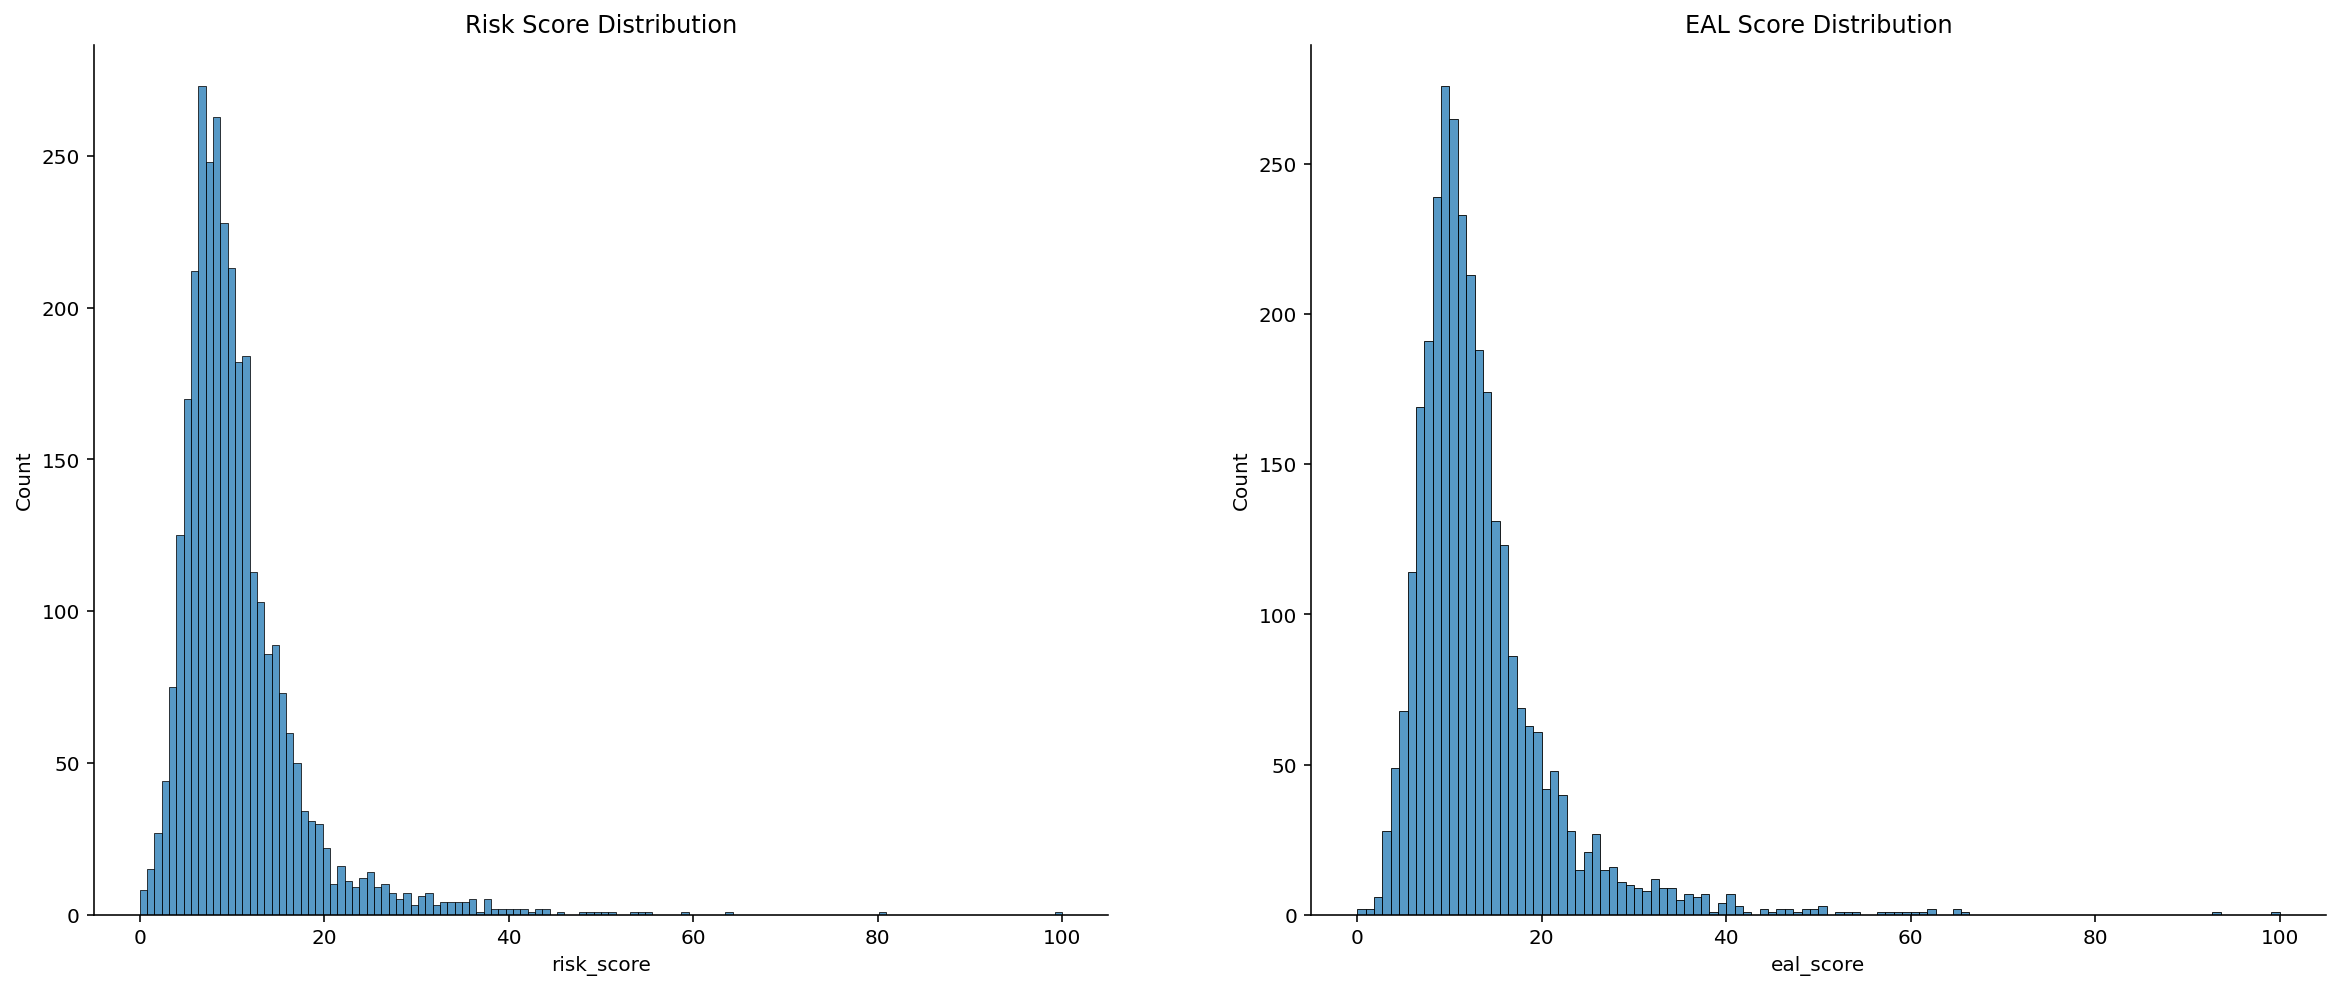

In [166]:
# get distribution of risk/eal score

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score', ax = ax1, data = df_nri)
sns.histplot(x='eal_score', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution')
ax2.set_title('EAL Score Distribution')

sns.despine()
plt.show()

For the most part, it seems like a fairly normal distribution. We can see that there is a slight right skew in both, so we will have to fix that before doing linear regression. 

In [167]:
df_nri['risk_score'].describe()

count    3142.000000
mean       10.603570
std         6.768475
min         0.000000
25%         6.689240
50%         9.089077
75%        12.533477
max       100.000000
Name: risk_score, dtype: float64

In [168]:
df_nri['eal_score'].describe()

count    3142.000000
mean       13.334561
std         7.736843
min         0.018372
25%         8.799945
50%        11.517427
75%        15.516319
max       100.000000
Name: eal_score, dtype: float64

#### The two distributions are right-skewed, so let's log-transform them.

In [169]:
# we do a log(x + .1) transformation because some x == 0 and we are unable to log those.
df_nri['risk_score_log10'] = np.log10(df_nri['risk_score'] + .1) 
df_nri['eal_score_log10'] = np.log10(df_nri['eal_score'] + .1) 

#### Let's see the log-transformed distributions.

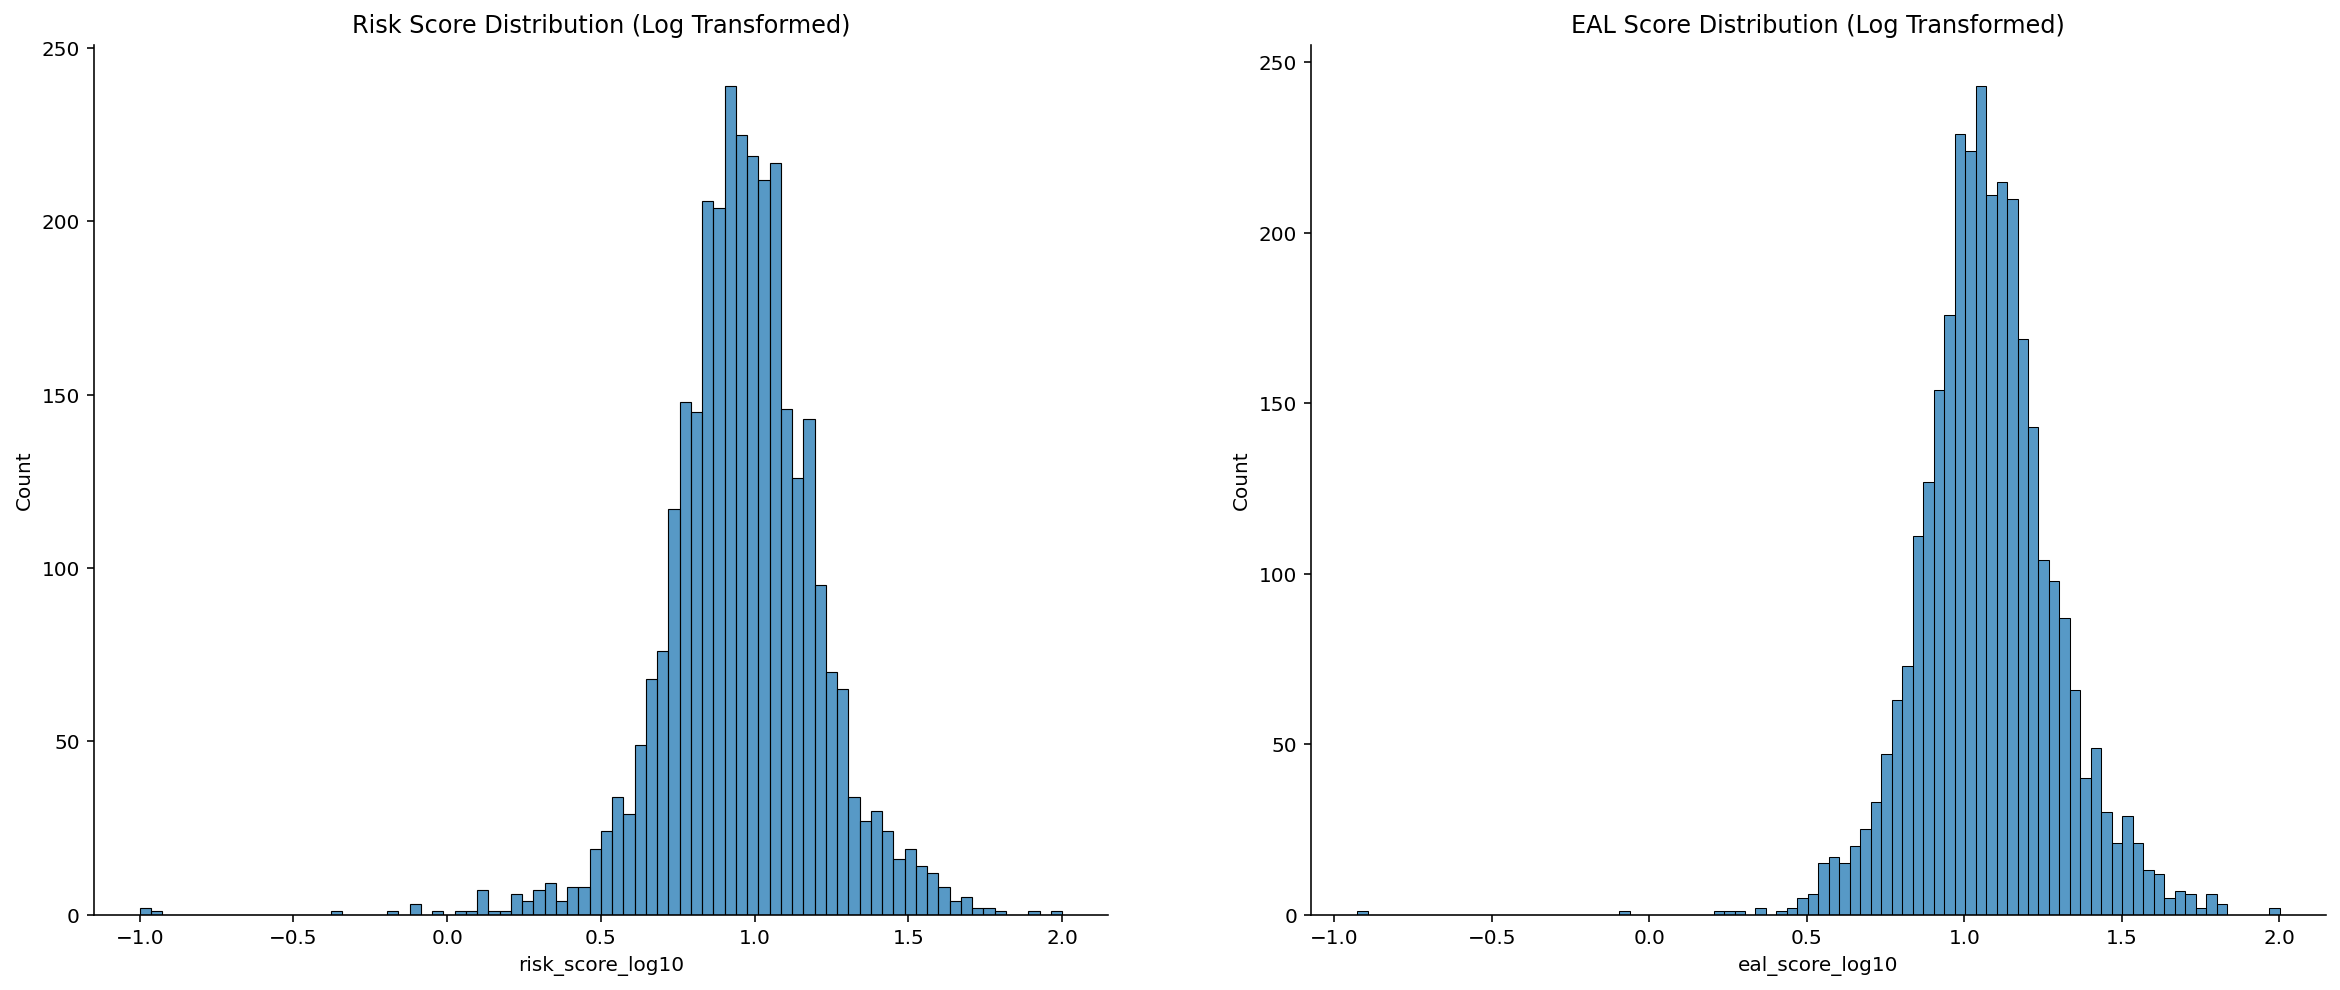

In [170]:
# get distribution of risk/eal score (log-transformed)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score_log10', ax = ax1, data = df_nri)
sns.histplot(x='eal_score_log10', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution (Log Transformed)')
ax2.set_title('EAL Score Distribution (Log Transformed)')

sns.despine()
plt.show()

### What's going on at the left-end of our distribution?
What counties are on the far left? What could be the reason?

In [171]:
df_nri[df_nri['risk_score_log10'] < -.5]

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,FIPS,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1479,Georgia,GA,13,Chattahoochee,053,11267,248.735663,0.009269,Very Low,4.693806,Very Low,13053,1,1,-0.961504,0.680680
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753
2902,Virginia,VA,51,Loudoun,107,312311,515.576847,0.000000,Very Low,17.339336,Relatively Moderate,51107,1,3,-1.000000,1.241530


In [172]:
df_nri[df_nri['eal_score_log10'] < -.5]

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,FIPS,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753


### Explanation
In Chattachoochee, GA, the frequency of natural disasters are well below the national average and the area is quite poor where around twenty percent of the population lives below the poverty line. These are among the many factors that contribute to low eal and risk scores.

We can see that Loving, TX is an outlier for both graphs. In fact, Loving, TX is the least populous county in all of the U.S and it consists of flat desert terrain with not much infrastructure. It makes sense that its eal and risk scores are low.  

For Loundon, VA, natural disasters rarely hit the area so its risk score is low. However, it is the richest county in the U.S, so its expected annual loss would be rated higher due to this fact.

### Which counties have the highest and lowest EAL score?

In [173]:
df_nri.sort_values(by = ['eal_score'], ascending = False)

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,FIPS,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,06,Los Angeles,037,9818605,4058.076752,100.000000,Very High,100.000000,Very High,6037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909
1295,California,CA,06,Santa Clara,085,1781642,1291.210369,22.951107,Relatively High,66.140195,Very High,6085,4,5,1.362692,1.821122
1285,California,CA,06,Riverside,065,2189641,7206.325086,58.865953,Very High,64.985716,Very High,6065,5,5,1.770601,1.813486
1253,California,CA,06,Alameda,001,1510271,737.476821,40.402820,Relatively High,64.799506,Very High,6001,4,5,1.607485,1.812241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Michigan,MI,26,Keweenaw,083,2156,540.111622,1.863178,Very Low,1.842344,Very Low,26083,1,1,0.292960,0.288326
1161,Alaska,AK,02,Wrangell,275,2369,2555.846403,2.229517,Very Low,1.743167,Very Low,2275,1,1,0.367266,0.265565
1155,Alaska,AK,02,Prince of Wales-Hyder,198,6172,5219.877753,1.633056,Very Low,1.511835,Very Low,2198,1,1,0.238813,0.207321
1615,Hawaii,HI,15,Kalawao,005,90,11.991403,1.636476,Very Low,0.704283,Very Low,15005,1,1,0.239669,-0.094591


### What counties have the highest and lowest risk score?

In [174]:
df_housing = pd.read_csv('datasets/cleaned/NewHousingPrices2017-2021.csv')
df_housing.head()

,County & State,FIPS,2017,2018,2019,2020,2021
0,"Autauga County, Alabama",1001,145203,144361,153716,160972,166318
1,"Baldwin County, Alabama",1003,185313,205764,209494,232730,243643
2,"Barbour County, Alabama",1005,97533,91965,100423,94615,99052
3,"Bibb County, Alabama",1007,116052,110683,101799,97807,102324
4,"Blount County, Alabama",1009,135375,128203,131548,134696,140916


## Linear Regression
#### Before applying linear regression, let's take a look at our correlations and outliers.

<AxesSubplot:xlabel='risk_score', ylabel='eal_score'>

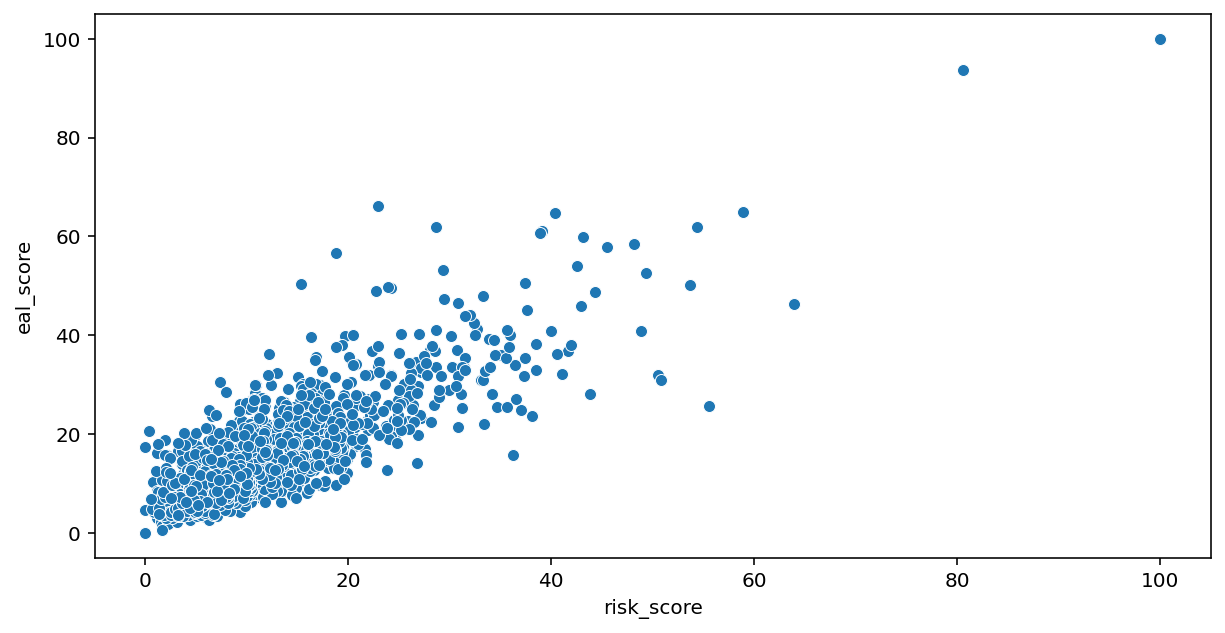

In [175]:
sns.scatterplot(x = 'risk_score', y = 'eal_score', data = df_nri)

### We can see that the most major outliers are the two on the far right. Let's find them.

In [176]:
df_nri.sort_values(by = ['risk_score'], ascending = False)

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,FIPS,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,06,Los Angeles,037,9818605,4058.076752,100.000000,Very High,100.000000,Very High,6037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909
1429,Florida,FL,12,Miami-Dade,086,2496435,1898.662364,63.926384,Very High,46.243703,Very High,12086,5,5,1.806359,1.665991
1285,California,CA,06,Riverside,065,2189641,7206.325086,58.865953,Very High,64.985716,Very High,6065,5,5,1.770601,1.813486
828,New York,NY,36,Bronx,005,1385108,42.050624,55.547136,Very High,25.603947,Relatively Moderate,36005,5,3,1.745443,1.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,Virginia,VA,51,Falls Church,610,12332,1.985292,0.586229,Very Low,6.946532,Very Low,51610,1,1,-0.163531,0.847975
1329,Colorado,CO,08,Douglas,035,285465,840.184666,0.341317,Very Low,20.669999,Relatively Moderate,8035,1,3,-0.355249,1.317436
1479,Georgia,GA,13,Chattahoochee,053,11267,248.735663,0.009269,Very Low,4.693806,Very Low,13053,1,1,-0.961504,0.680680
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753


Here, we can see that Los Angeles, CA takes the number one spot in both categories. This makes sense because EAL is calculated via anticipated loss in both the economy and population, both of which LA has a large amounts of. Also, LA is hit with an abundance of wildfires and earthquakes, which (among other factors), influence risk score.

<AxesSubplot:xlabel='risk_score', ylabel='eal_score'>

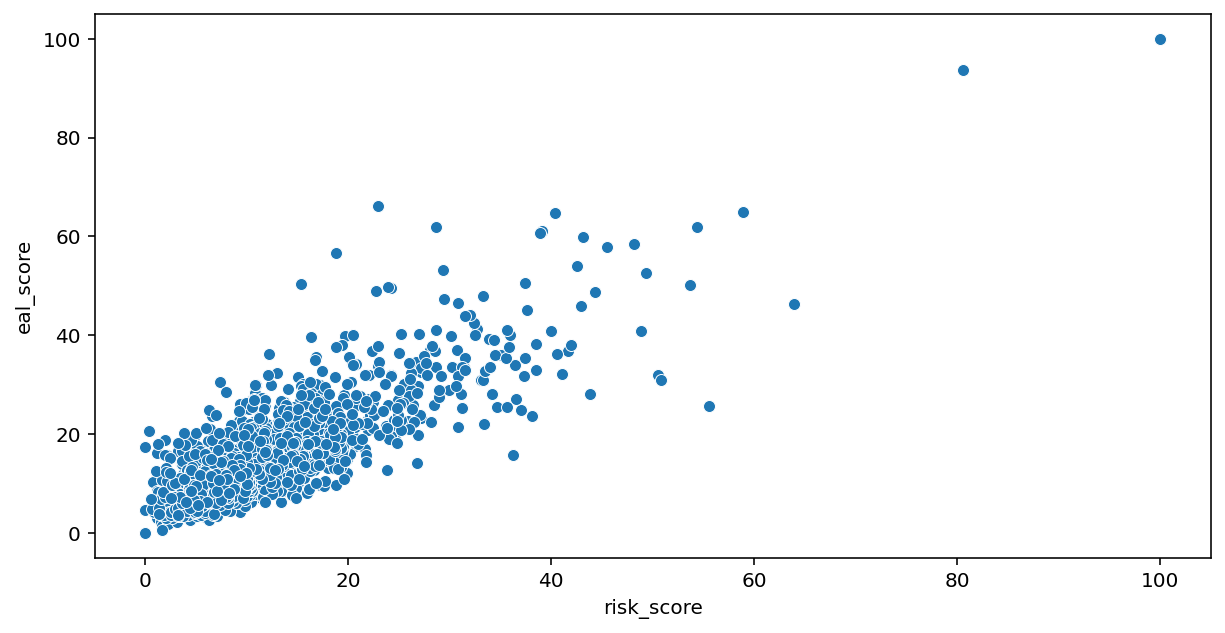

In [177]:
sns.scatterplot(x = 'risk_score', y = 'eal_score', data = df_nri)

### We can see that the most major outliers are the two on the far right. Let's find them.

In [178]:
outliers = df_nri[df_nri['risk_score'] > 80]
outliers

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,FIPS,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,06,Los Angeles,037,9818605,4058.076752,100.000000,Very High,100.000000,Very High,6037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909


Los Angeles, CA is the most populous county is the US and Harris, TX is the third most populous county. Both are hit with natural disasters very frequently and both have a lot to lose when those disasters do strike.

### The scatter matrix
It is clear that there is a positive correlation between eal score and risk score

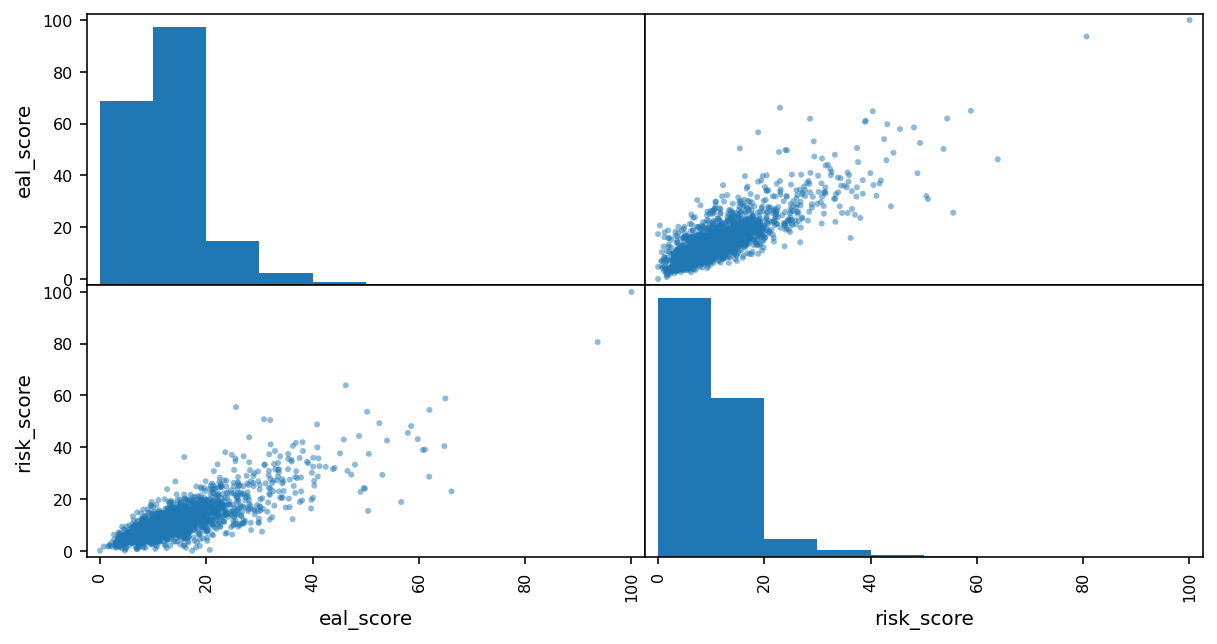

In [179]:
fig = pd.plotting.scatter_matrix(df_nri[['eal_score','risk_score']])

### We can use linear regression to see the correlation between risk_score and expected annual loss.

We will use the log-transformed values.

In [180]:
outcome, predictors = patsy.dmatrices('risk_score_log10 ~ eal_score_log10', df_nri)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       risk_score_log10   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     4481.
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:13:34   Log-Likelihood:                 1382.7
No. Observations:                3142   AIC:                            -2761.
Df Residuals:                    3140   BIC:                            -2749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0255      0.014     

##### By our adjusted r-squared, we can see that there is a correlation between risk and expected annual loss in a county.

## Let's create a choropleth of all counties risk_score in the US

In [181]:
# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['fips'] = df_nri['state_fips'] + df_nri['county_fips']

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

### Choropleth for risk score

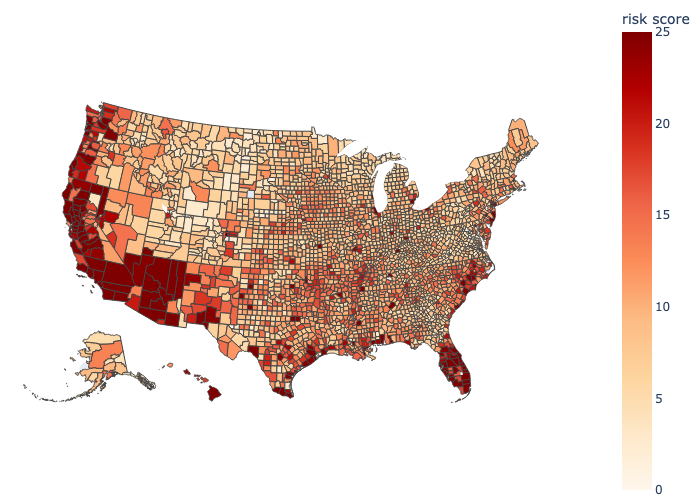

In [182]:
# View the color options below
# https://plotly.com/python/builtin-colorscales/

fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='risk_score',
                           color_continuous_scale="OrRd",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'risk_score':'risk score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/risk_choropleth.png")
Image(filename='images/risk_choropleth.png') 


### Choropleth for eal score

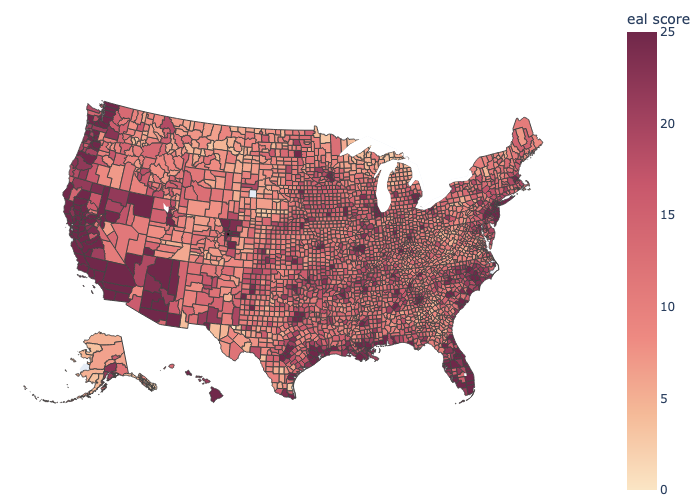

In [183]:
fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='eal_score',
                           color_continuous_scale="Burgyl",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'eal_score':'eal score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/eal_choropleth.png")
Image(filename='images/eal_choropleth.png') 

# EDA on dataframe containing averages by state and cost of living by state (merged_df)

First, we took a look at the numerical summaries for each column to get an idea of the distributions of each of the variables. The variables that will be relevant to answering the second part of our research question are fatalities, injuries, property_damge, and costIndex.

In [184]:
merged_df.describe()

,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,9.320000,28.120000,545.097567,32.664367,577.761600,104.634000
std,12.973191,37.657772,1920.540301,93.499721,1945.296879,20.600224
min,0.000000,0.000000,0.098333,0.000000,0.098333,86.100000
25%,2.000000,4.250000,14.635833,0.015000,15.633333,90.275000
50%,5.000000,14.000000,41.960833,0.601667,49.191667,97.600000
75%,10.000000,31.500000,132.265417,9.148333,203.102083,110.450000
max,62.000000,173.000000,12556.576667,520.446667,12681.946667,192.900000


To address our second part of our research question (in which state does the impact of natural disasters affect cost of living the most in terms of injuries, casualities, and property damage?), we looked at the distributions of the cost of living index, fatalities, and injuries variables using boxplots. These distributions all appear right skewed towards higher cost of living, higher number of fatalities, and higher number of injuries. Each of these distributions have a few outliers that were identified after plotting the boxplots. To visualize the property damage variable distribution, we generated a histogram, which appears right skewed. A few outliers with a high amount of property damage were identified afterwards. Note that we did not choose to use a boxplot for property damage because there is an extreme outlier that obscured the visualization of the IQR of the boxplot. When examining the outliers for the injuries, casualities, and property damage variables, California appeared in all of the outliers.

Additionally, we looked at the relationship between the cost of living index with injuries, casualities, and property damage by generating scatterplots and calculating correlation values of cost of living index with injuries, casualities, and property damage. The correlation values suggest that there are weak, negative correlations between cost of living with injuries, cost of loving with casualities, and cost of living with property damage.

(array([ 80., 100., 120., 140., 160., 180., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

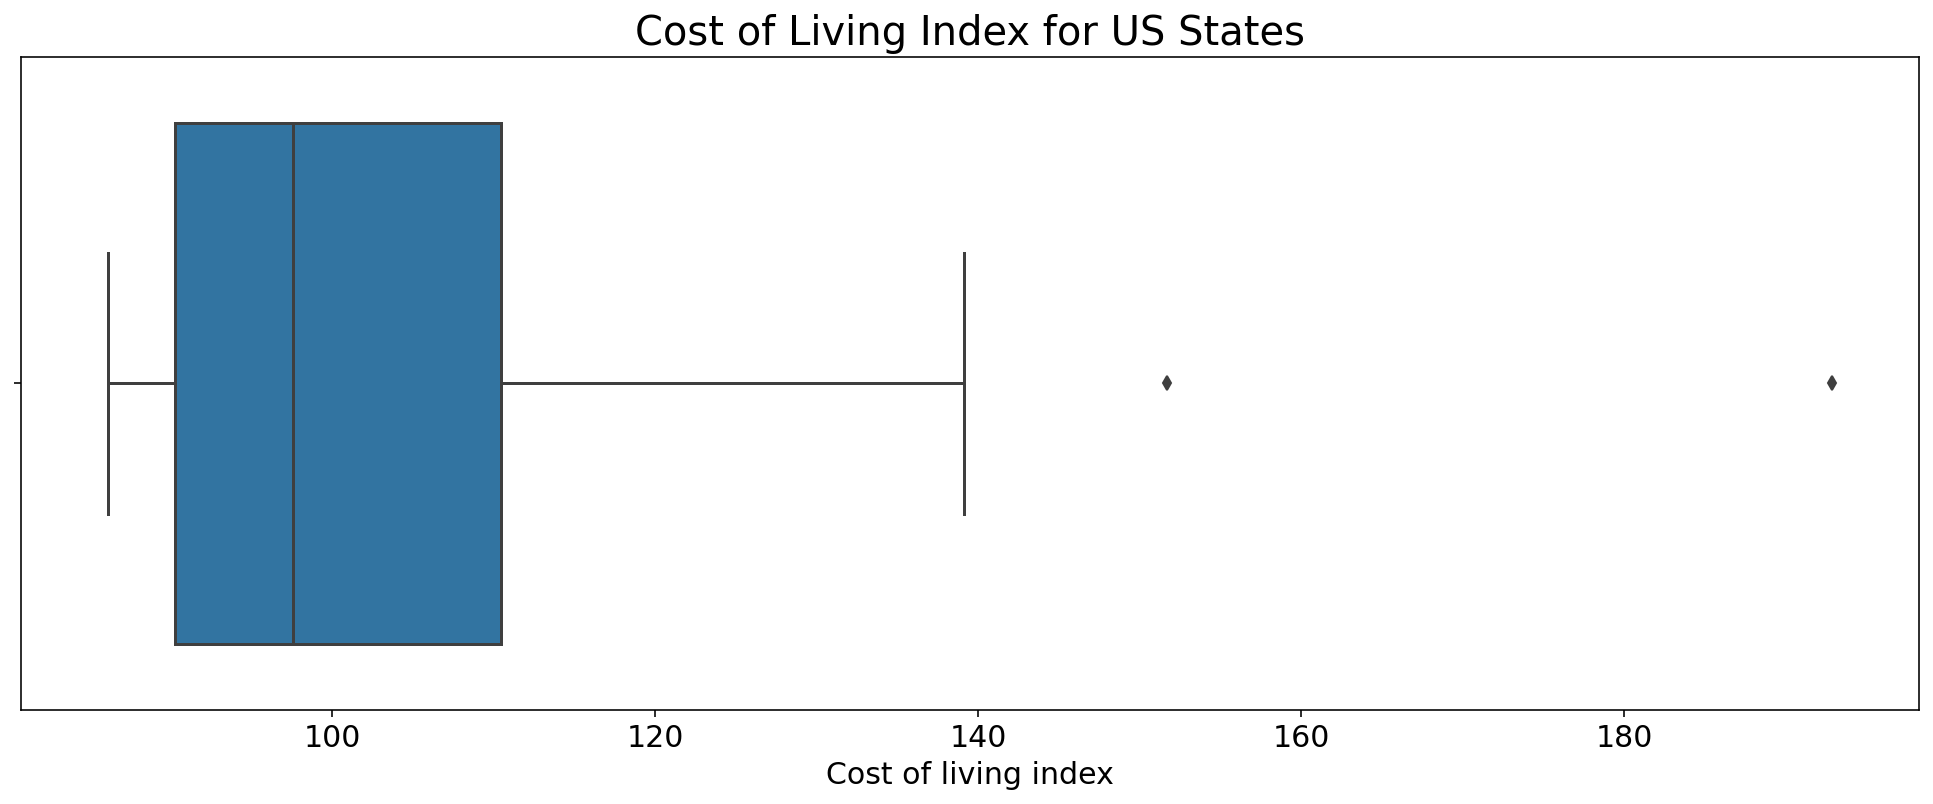

In [185]:
plt.rcParams['figure.figsize'] = (17, 6)
col_boxplot = sns.boxplot(x= 'costIndex', data= merged_df)
col_boxplot.set_title('Cost of Living Index for US States', fontsize= 20)
col_boxplot.set_xlabel('Cost of living index', fontsize= 15)
plt.xticks(fontsize=15)

In [186]:
# look at outliers
merged_df[merged_df['costIndex'] > 140]

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
4,California,47,136,3456.025,28.540000,3484.560000,151.7
10,Hawaii,2,3,9.985,0.026667,10.011667,192.9


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

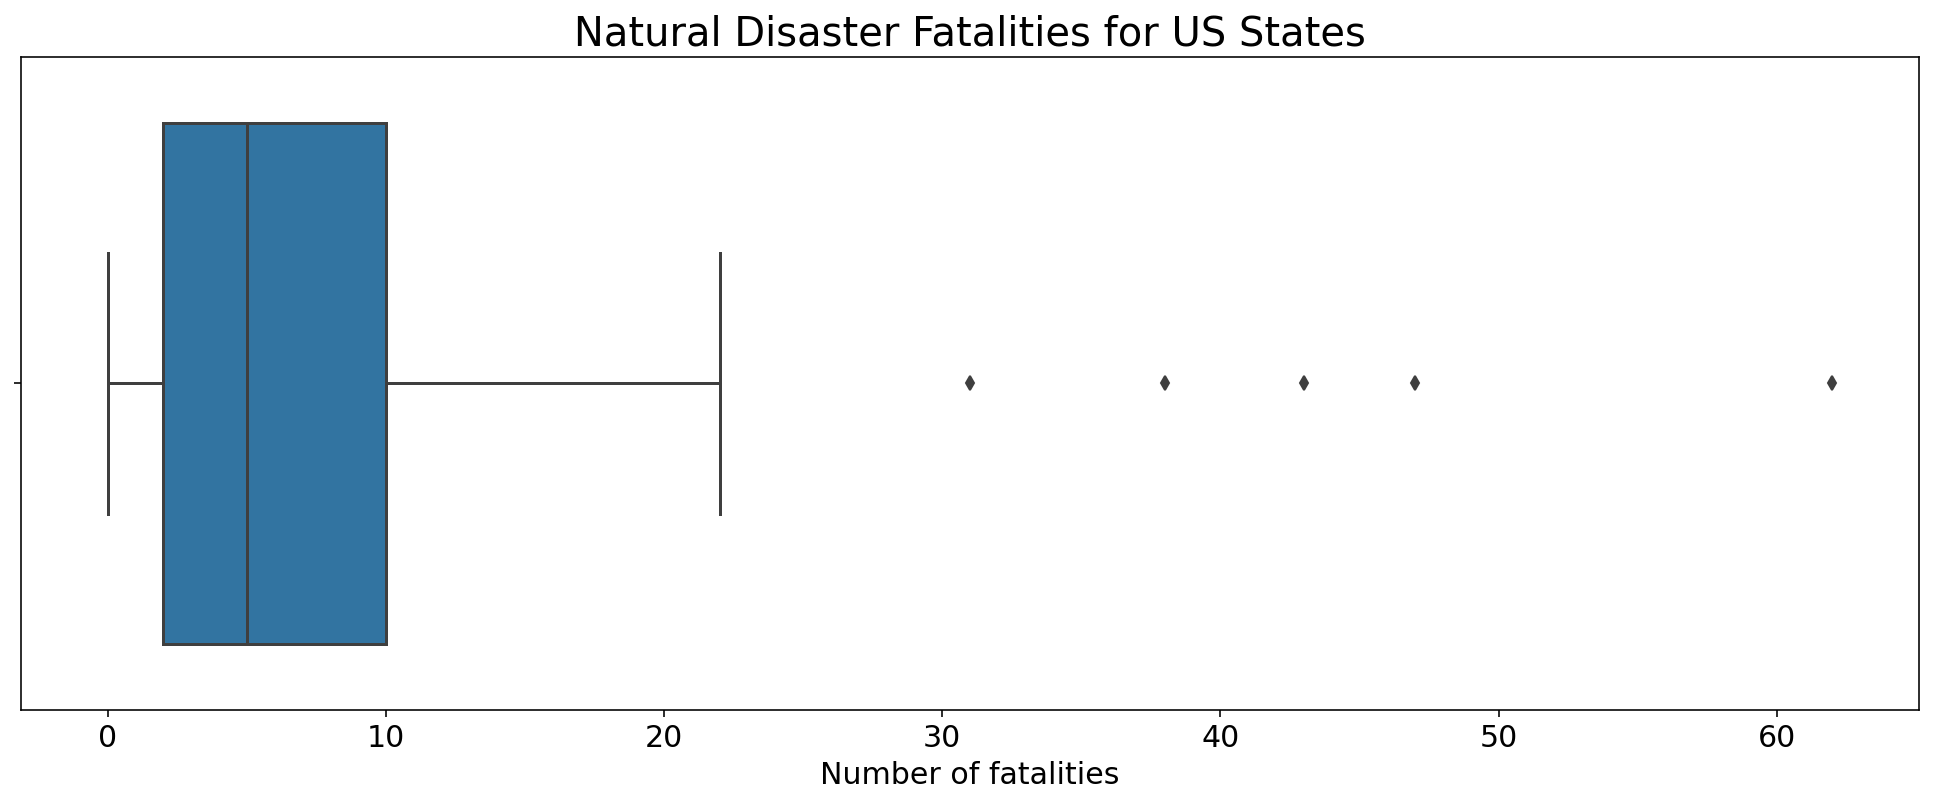

In [187]:
fatalities_boxplot = sns.boxplot(x= 'fatalities', data= merged_df)
fatalities_boxplot.set_title('Natural Disaster Fatalities for US States', fontsize= 20)
fatalities_boxplot.set_xlabel('Number of fatalities', fontsize= 15)
plt.xticks(fontsize=15)

In [188]:
# look at outliers
merged_df[merged_df['fatalities'] > 25]

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
2,Arizona,38,28,19.115000,0.775000,19.890000,97.0
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
8,Florida,31,61,2893.845000,370.981667,3264.826667,97.9
27,Nevada,43,7,20.563333,0.000000,20.563333,108.5
42,Texas,62,173,12556.576667,125.370000,12681.946667,91.5


In [189]:
top10_fatalities = merged_df.sort_values(by= 'fatalities', ascending= False).head(10)
top10_fatalities

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
42,Texas,62,173,12556.576667,125.370000,12681.946667,91.5
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
27,Nevada,43,7,20.563333,0.000000,20.563333,108.5
2,Arizona,38,28,19.115000,0.775000,19.890000,97.0
8,Florida,31,61,2893.845000,370.981667,3264.826667,97.9
32,North Carolina,22,19,528.508333,101.398333,629.905000,94.9
0,Alabama,13,42,62.233333,0.346667,62.580000,89.3
41,Tennessee,13,69,318.650000,0.580000,319.230000,88.7
12,Illinois,12,30,66.075000,2.590000,68.663333,94.5
24,Missouri,12,114,84.230000,3.913333,88.145000,87.1


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

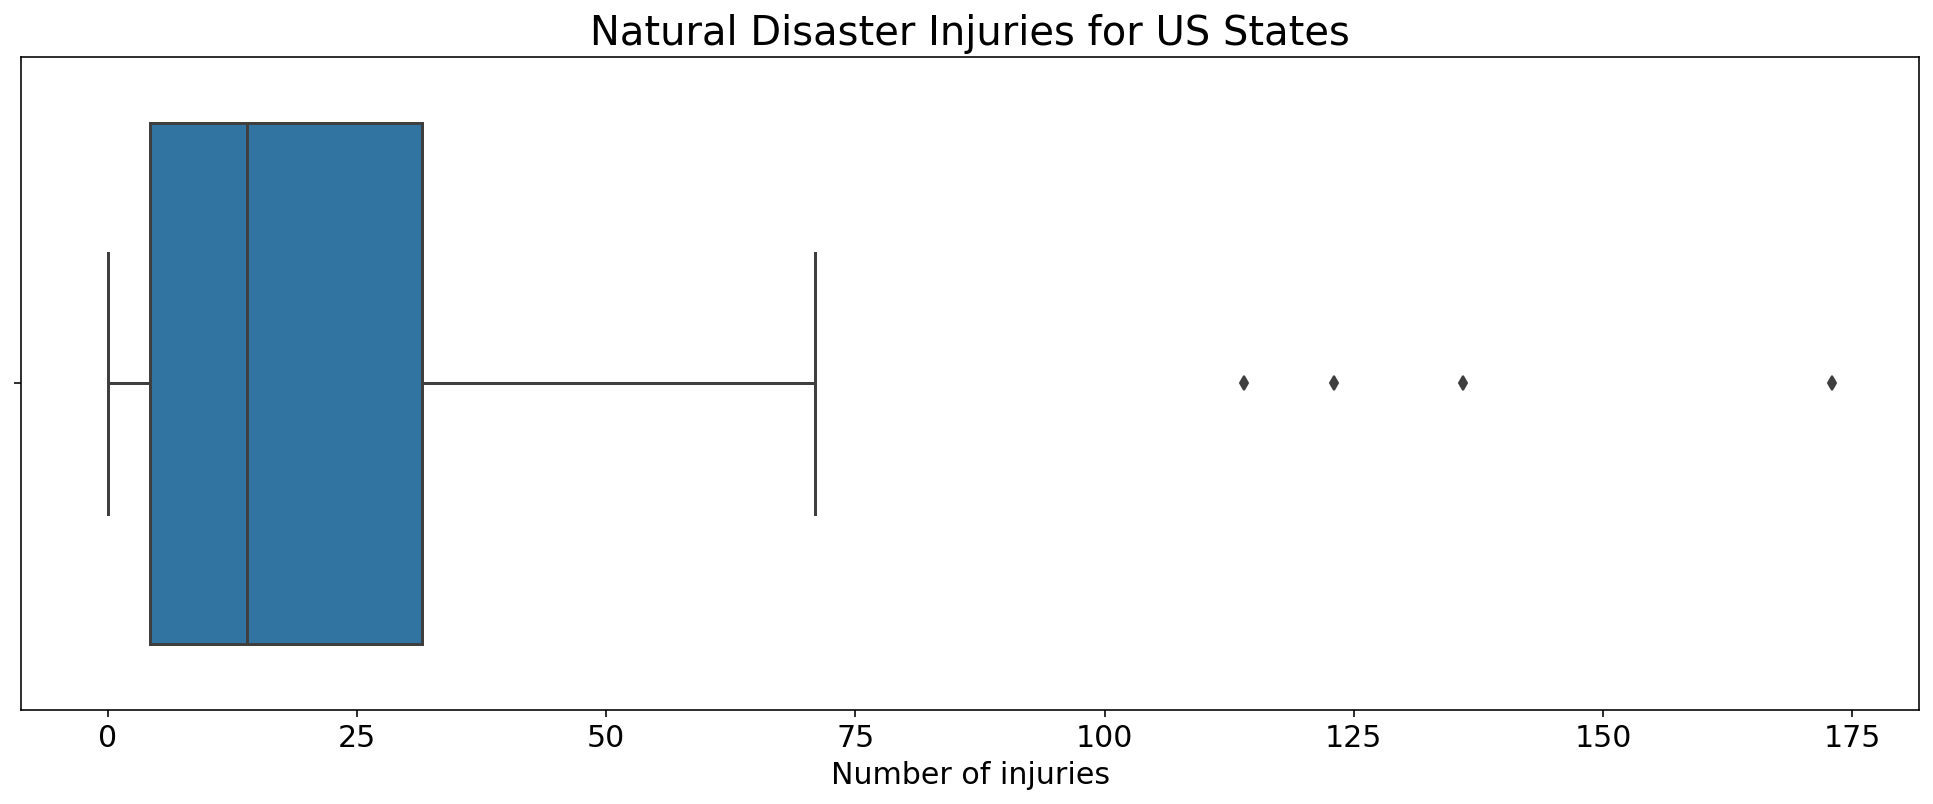

In [190]:
injuries_boxplot = sns.boxplot(x= 'injuries', data= merged_df)
injuries_boxplot.set_title('Natural Disaster Injuries')
injuries_boxplot.set_title('Natural Disaster Injuries for US States', fontsize= 20)
injuries_boxplot.set_xlabel('Number of injuries', fontsize= 15)
plt.xticks(fontsize=15)

In [191]:
# look at outliers
merged_df[merged_df['injuries'] > 75]

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
24,Missouri,12,114,84.230000,3.913333,88.145000,87.1
35,Oklahoma,10,123,51.871667,0.006667,51.880000,87.0
42,Texas,62,173,12556.576667,125.370000,12681.946667,91.5


(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

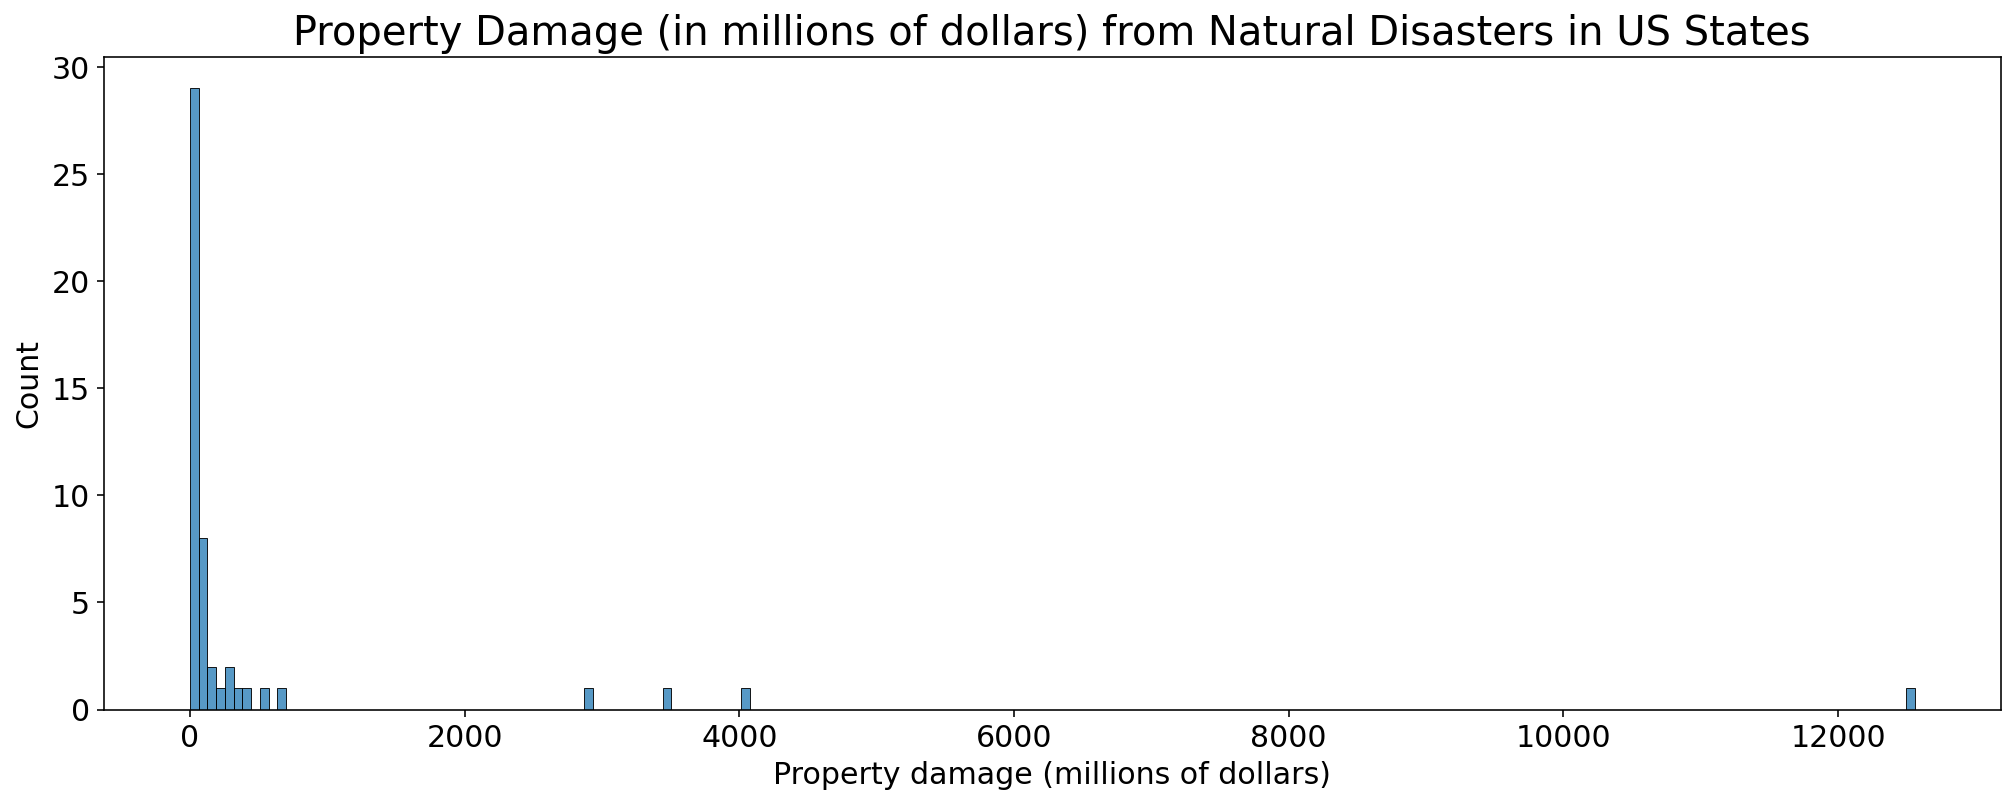

In [192]:
property_damage_hist = sns.histplot(x= 'property_damage', data= merged_df)
property_damage_hist.set_title('Property Damage (in millions of dollars) from Natural Disasters in US States', 
                               fontsize= 20)
property_damage_hist.set_xlabel('Property damage (millions of dollars)', fontsize= 15)
property_damage_hist.set_ylabel('Count', fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [193]:
# look at outliers
merged_df[merged_df['property_damage'] > 2000]

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
8,Florida,31,61,2893.845000,370.981667,3264.826667,97.9
17,Louisiana,10,42,4033.888333,0.638333,4034.526667,93.9
42,Texas,62,173,12556.576667,125.370000,12681.946667,91.5


(array([ 80., 100., 120., 140., 160., 180., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

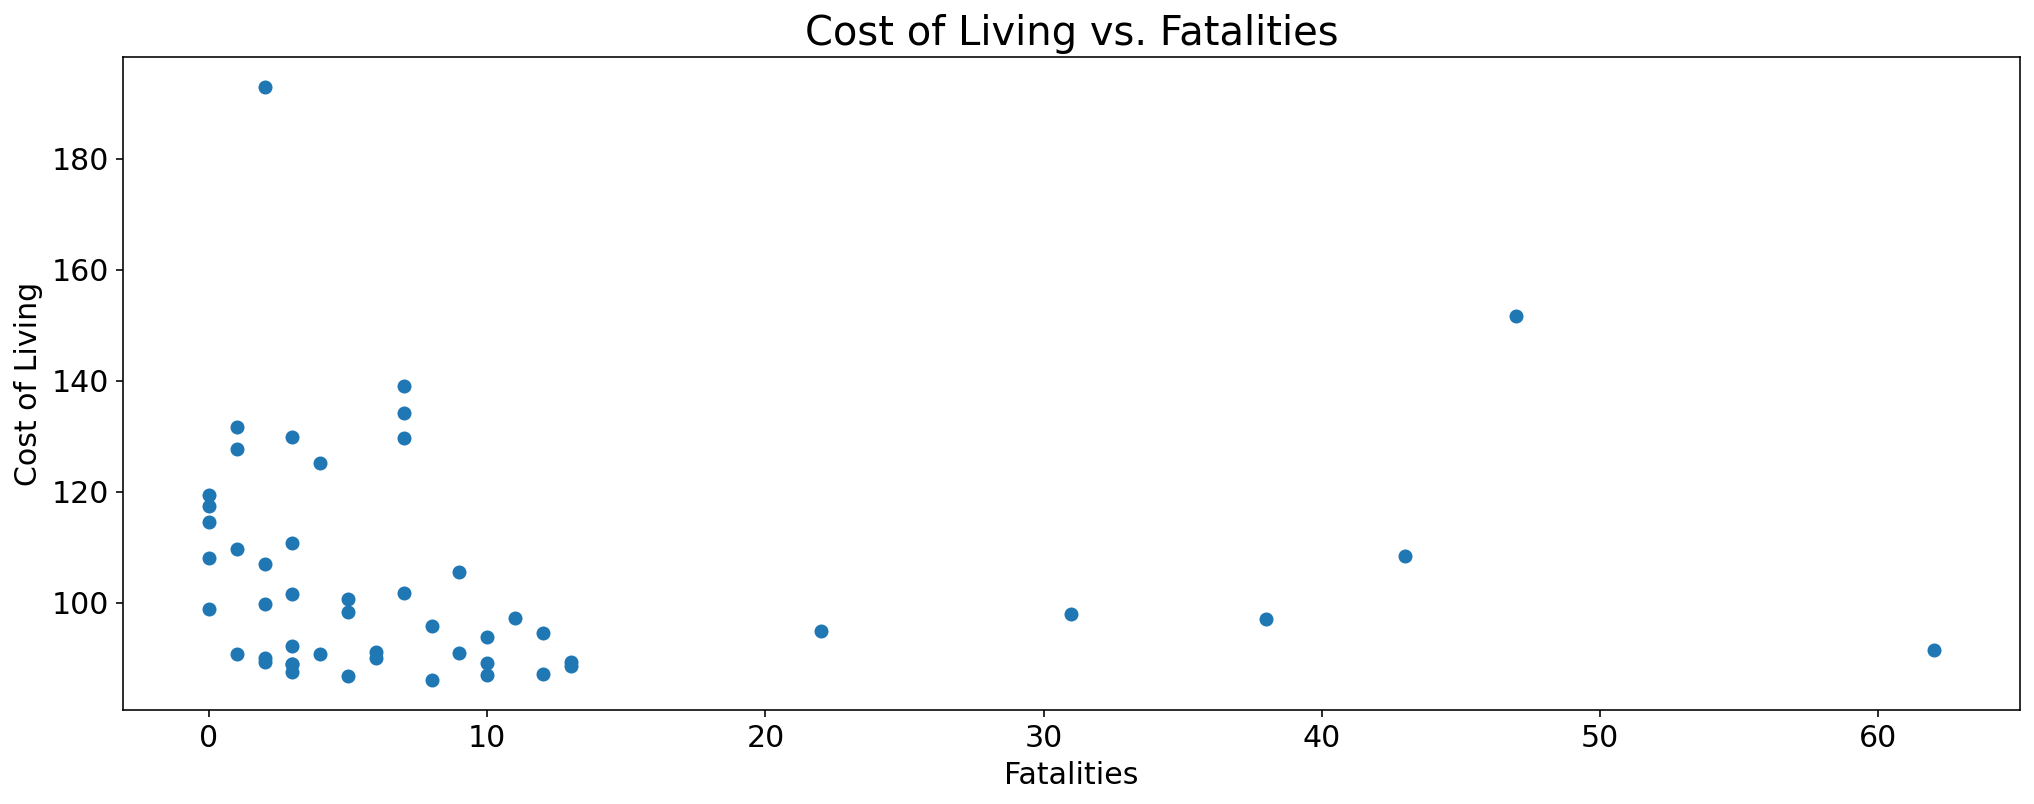

In [194]:
fatalities_col_scatterplot = plt.scatter(x= 'fatalities', y= 'costIndex', data= merged_df)
plt.title('Cost of Living vs. Fatalities', fontsize= 20)
plt.xlabel('Fatalities', fontsize= 15)
plt.ylabel('Cost of Living', fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([ 80., 100., 120., 140., 160., 180., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

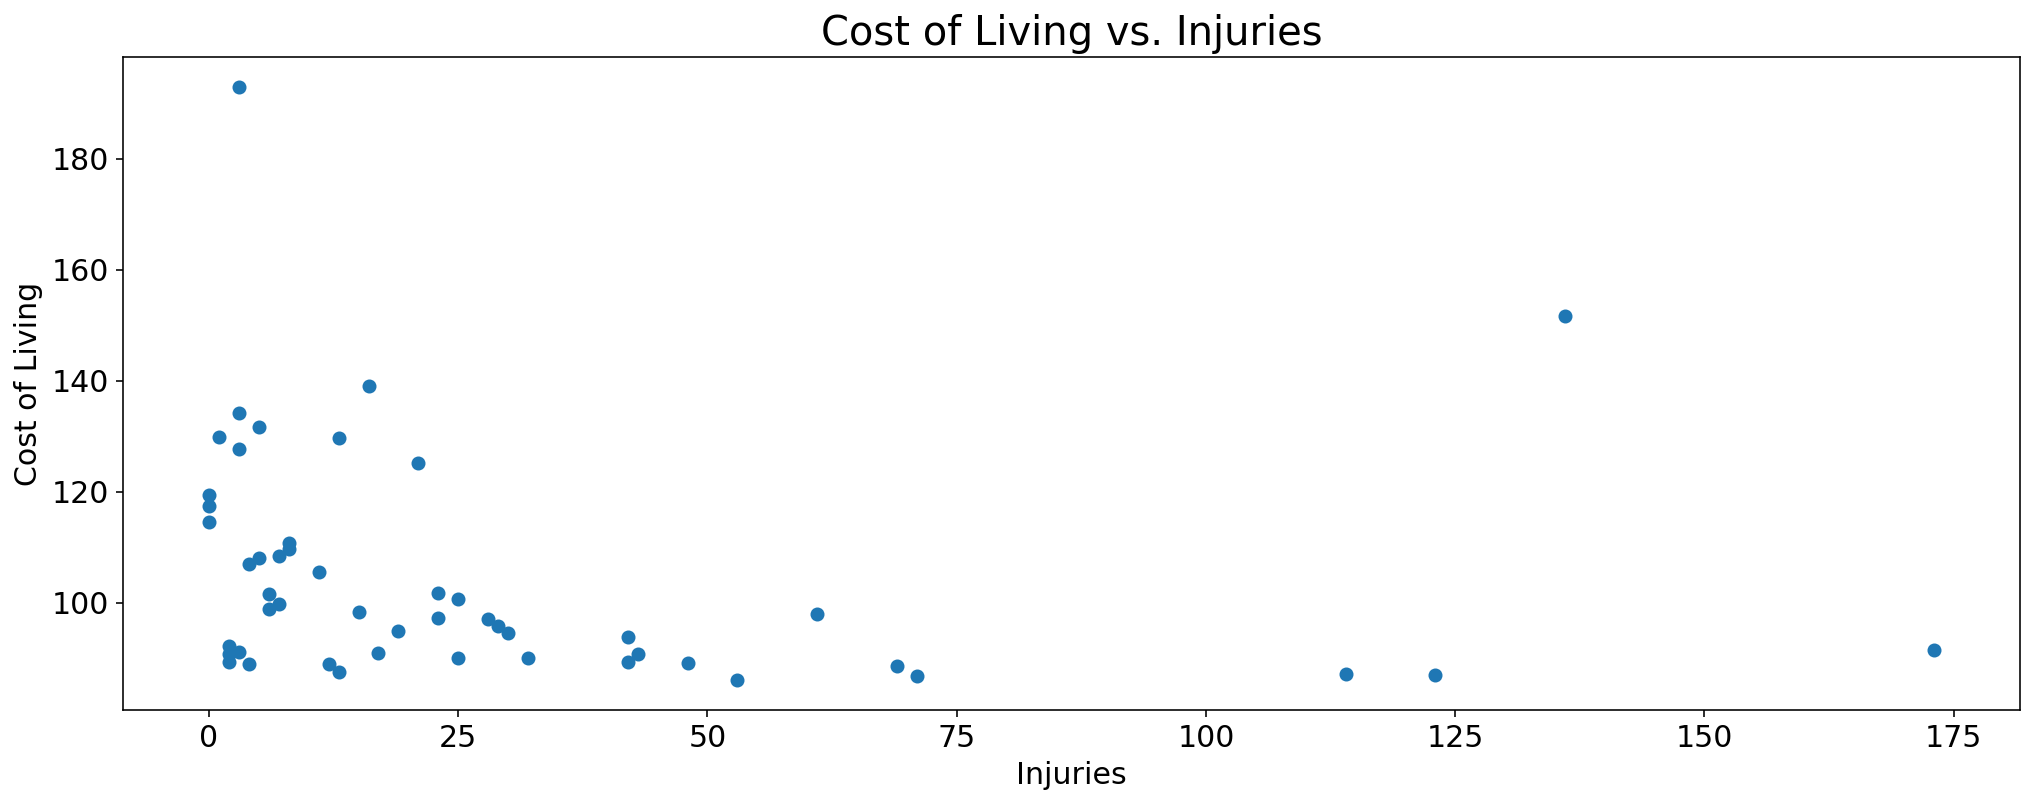

In [195]:
plt.scatter(x= 'injuries', y= 'costIndex', data= merged_df)
plt.title('Cost of Living vs. Injuries', fontsize= 20)
plt.xlabel("Injuries", fontsize= 15)
plt.ylabel("Cost of Living", fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([ 80., 100., 120., 140., 160., 180., 200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

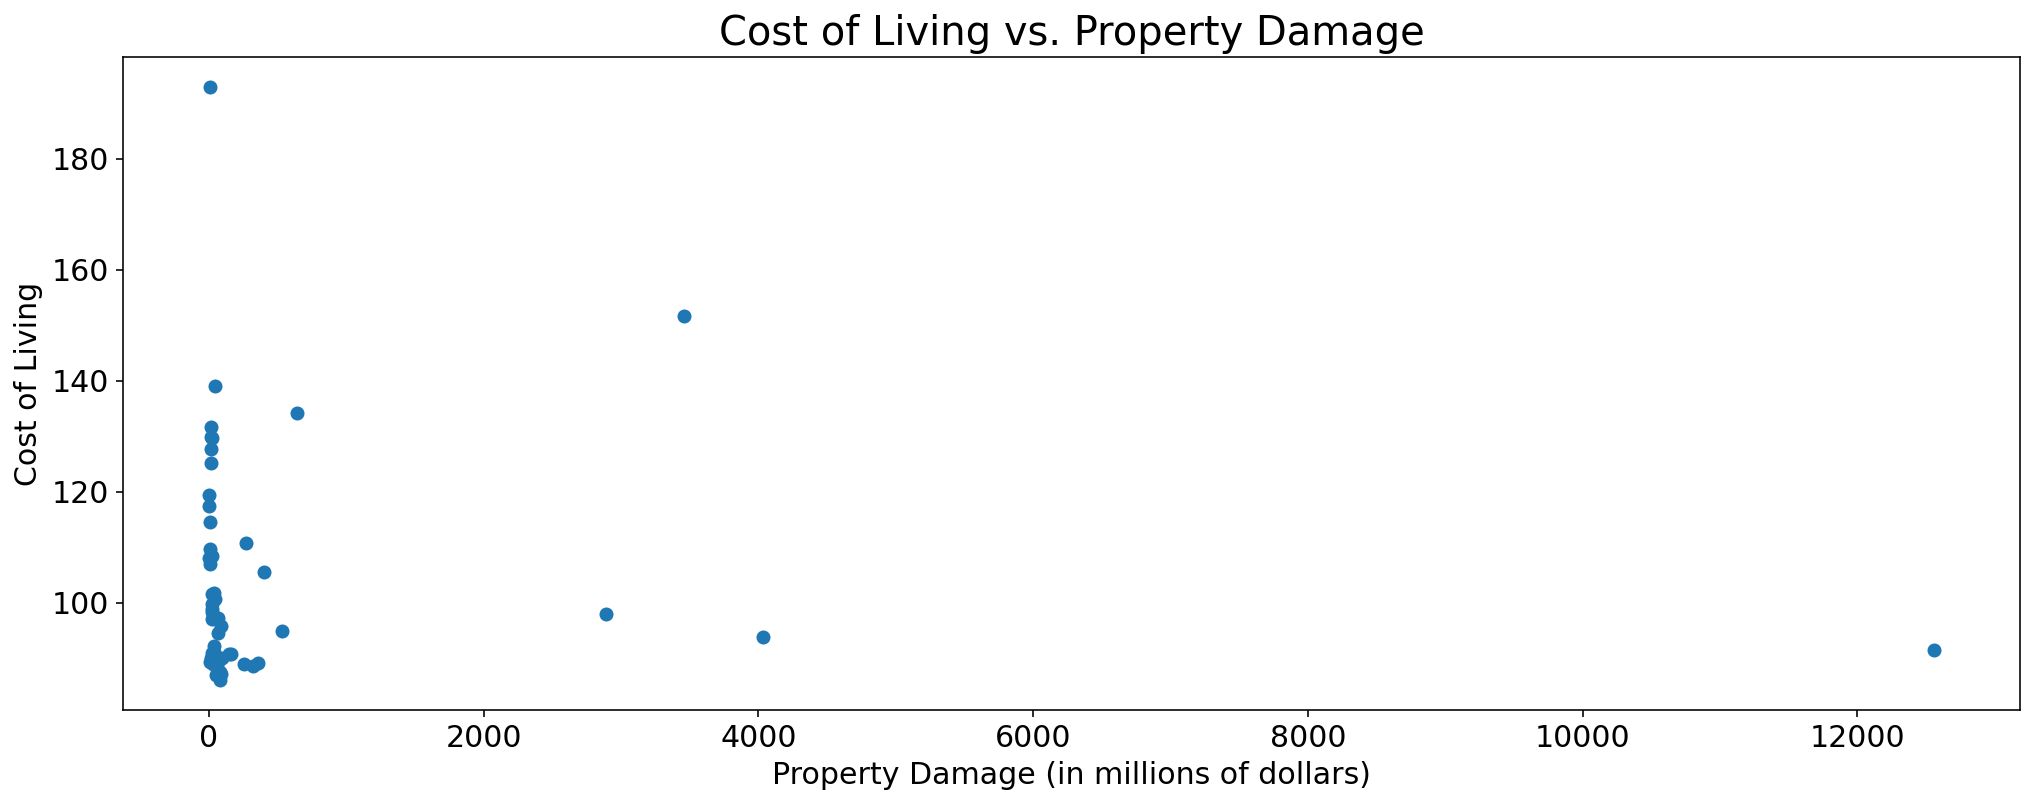

In [196]:
plt.scatter(x= 'property_damage', y= 'costIndex', data= merged_df)
plt.title('Cost of Living vs. Property Damage', fontsize= 20)
plt.xlabel("Property Damage (in millions of dollars)", fontsize= 15)
plt.ylabel("Cost of Living", fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Calculate correlation values for all variabes in the dataframe. The relevant correlations are:

cost of living index vs fatalities: -0.027700 <br>
cost of living index vs injuries: -0.192323 <br>
cost of living index vs property damage: -0.039899 <br>

In [197]:
merged_df.corr()

,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
fatalities,1.000000,0.658607,0.701369,0.249536,0.704437,-0.027700
injuries,0.658607,1.000000,0.657714,0.219319,0.659885,-0.192323
property_damage,0.701369,0.657714,1.000000,0.242143,0.998912,-0.039899
crop_damage,0.249536,0.219319,0.242143,1.000000,0.287125,-0.166547
total_damage,0.704437,0.659885,0.998912,0.287125,1.000000,-0.047396
costIndex,-0.027700,-0.192323,-0.039899,-0.166547,-0.047396,1.000000


## EDA on Table #6 (Climate)

We created a Choropleth Map for Average Climate by County to help visualize climates across the United States

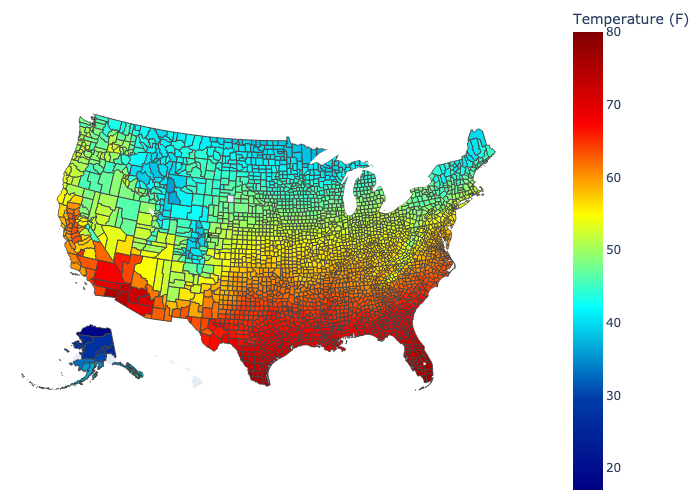

In [198]:
#Choropleth map by county for Climate
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
fig = px.choropleth(climate_df, geojson=counties, locations='fips', color='Temperature (F)',
                           color_continuous_scale="Jet",
                           range_color=(17, 80),
                           scope="usa",
                           labels={'Temperature (F)':'Temperature (F)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/climate_choropleth.png")
Image(filename='images/climate_choropleth.png') 

## EDA on Table #9 (Cost of Living + Climate)

In [199]:
#Choropleth map by county for COL, currently not used

# fig = px.choropleth(col_df, geojson=counties, locations='fips', color='Cost of Living Index',
#                            color_continuous_scale="Jet",
#                            range_color=(80, 180),
#                            scope="usa",
#                            #labels={'Temperature (F)':'Temperature (F)'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show() 


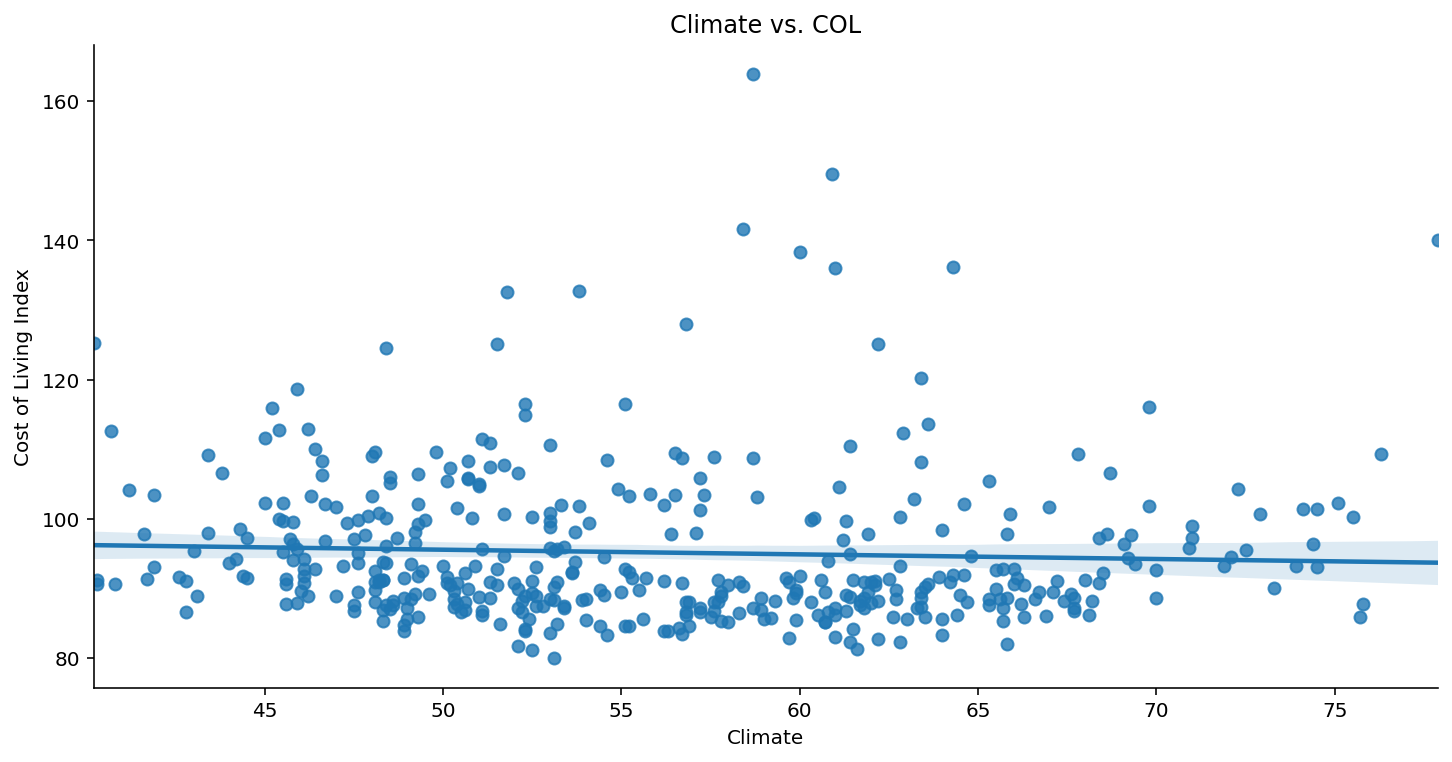

In [200]:
#Scatterplot of Climate and Cost of Living
sns.lmplot(data = both_df, x = 'Climate', y = 'Cost of Living Index', aspect = 2).set(title='Climate vs. COL')

There seems to be a very weak negative correlation if at all when using a linear regression model. Most of the points lie around a 90 COL Index, with very few points above 130. We find the exact correlation below.

In [201]:
#Calculates correlation between Climate and Cost of Living
both_df.corr()

,Cost of Living Index,Climate
Cost of Living Index,1.00000,-0.04992
Climate,-0.04992,1.00000


As we can see, the correlation between Climate and Cost of Living is -0.06, so there is an extremely weak negative correlation between the two variables. 

# EDA on Housing Price (Table #10)

In [202]:
df_housing = pd.read_csv('datasets/cleaned/NewHousingPrices2017-2021.csv')
df_nri = pd.read_csv('datasets/cleaned/nri.csv')

## Merge Housing and NRI

In [203]:
df_housing_nri_merged = pd.merge(df_housing, df_nri, how ='outer', on =['FIPS'])
df_housing_nri_merged.dropna(how='any', inplace = True)

df_housing_nri_merged['FIPS'] = df_housing_nri_merged['FIPS'].apply(lambda x: str(x))
df_housing_nri_merged['FIPS'] = df_housing_nri_merged['FIPS'].apply(lambda x: x.zfill(5))

In [204]:
df_housing_nri_merged

,County & State,FIPS,2017,2018,2019,2020,2021,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,risk_encoded,eal_encoded
0,"Autauga County, Alabama",01001,145203.0,144361.0,153716.0,160972.0,166318.0,Alabama,AL,1,Autauga,1,54571,594.448312,5.748777,Very Low,10.687727,Relatively Low,1,2
1,"Baldwin County, Alabama",01003,185313.0,205764.0,209494.0,232730.0,243643.0,Alabama,AL,1,Baldwin,3,182265,1589.815853,13.557905,Relatively Moderate,18.735079,Relatively Moderate,3,3
2,"Barbour County, Alabama",01005,97533.0,91965.0,100423.0,94615.0,99052.0,Alabama,AL,1,Barbour,5,27457,885.001636,9.419639,Relatively Low,11.935457,Relatively Low,2,2
3,"Bibb County, Alabama",01007,116052.0,110683.0,101799.0,97807.0,102324.0,Alabama,AL,1,Bibb,7,22915,622.460425,4.346314,Very Low,9.076046,Very Low,1,1
4,"Blount County, Alabama",01009,135375.0,128203.0,131548.0,134696.0,140916.0,Alabama,AL,1,Blount,9,57322,644.821022,9.362945,Relatively Low,14.548375,Relatively Low,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,"Teton County, Wyoming",56039,746088.0,769415.0,867907.0,894286.0,938682.0,Wyoming,WY,56,Teton,39,21294,3996.855337,6.513988,Very Low,15.004361,Relatively Low,1,2
3113,"Uinta County, Wyoming",56041,191340.0,185717.0,186190.0,180591.0,189556.0,Wyoming,WY,56,Uinta,41,21118,2081.651840,4.458528,Very Low,8.437977,Very Low,1,1
3114,"Washakie County, Wyoming",56043,174124.0,172288.0,170665.0,171097.0,179590.0,Wyoming,WY,56,Washakie,43,8533,2238.665800,5.182977,Very Low,5.592578,Very Low,1,1
3115,"Weston County, Wyoming",56045,192965.0,187487.0,178218.0,171613.0,180132.0,Wyoming,WY,56,Weston,45,7208,2398.003888,3.968561,Very Low,6.318677,Very Low,1,1


# Distributions
We will take a look at how our housing price is distributed among counties in the US

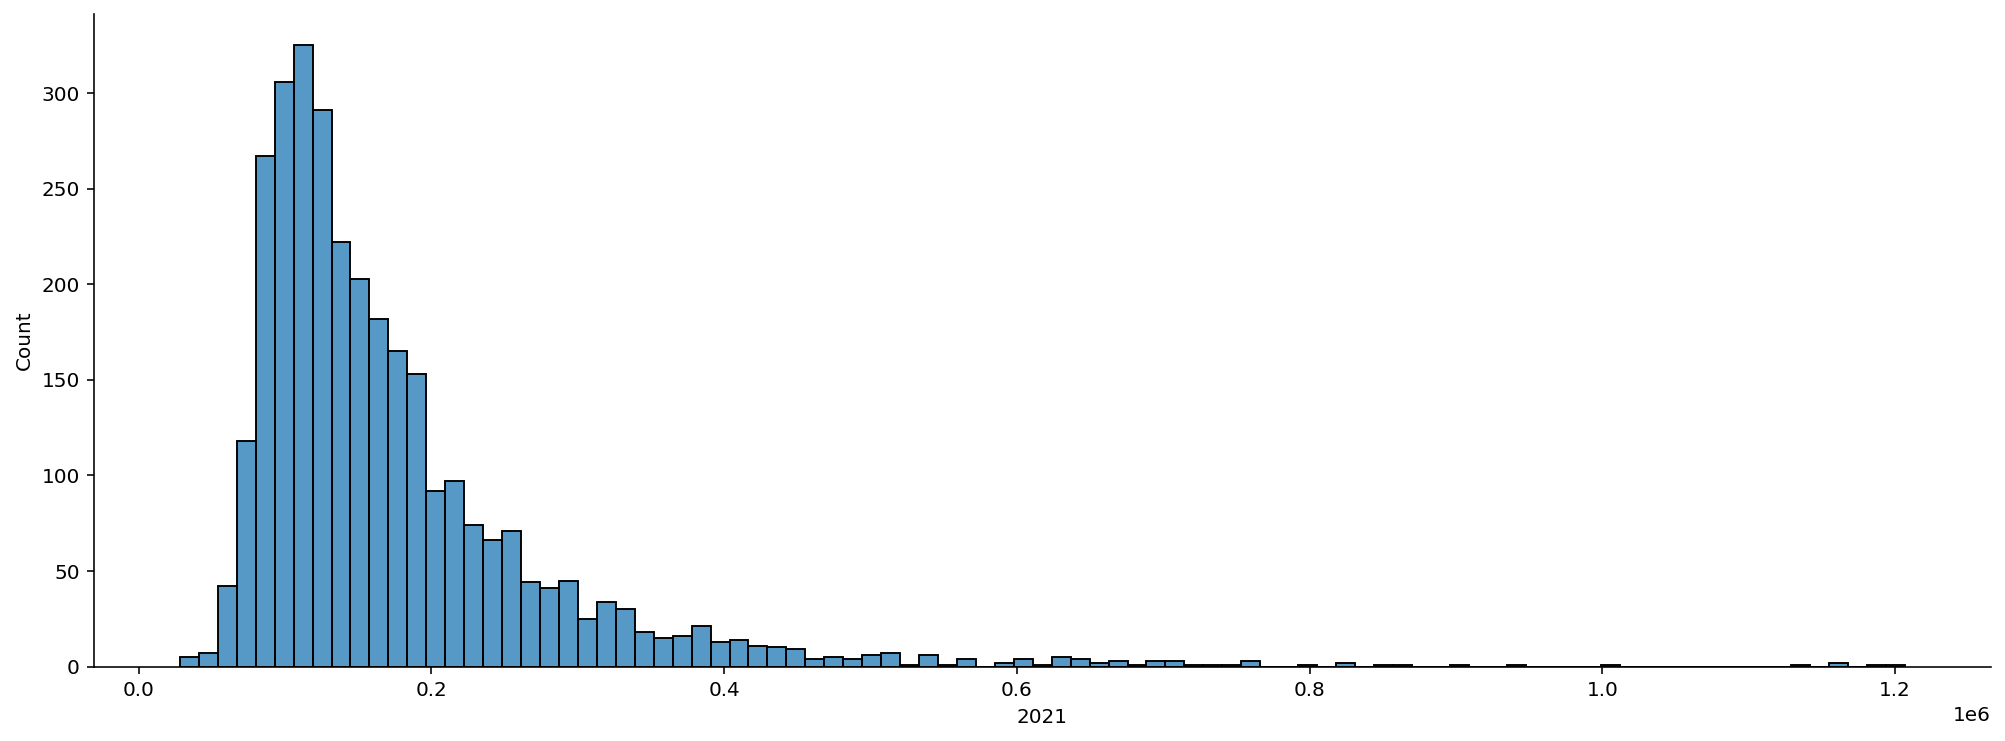

In [205]:
# get distribution of housing price

sns.histplot(x='2021', data = df_housing_nri_merged)
ax1.set_title('Housing Price Distribution (2021)')

sns.despine()
# plt.show()

There is a right skew so let's boxcox transform the data so that we can apply regression.

## Boxcox Transforming Our 2021 Housing Prices

In [206]:
fitted_data, fitted_lambda = boxcox(df_housing_nri_merged['2021'])
df_housing_nri_merged['2021_boxcox'] = fitted_data

In [207]:
df_housing_nri_merged.head()

,County & State,FIPS,2017,2018,2019,2020,2021,state,state_abbrv,state_fips,...,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,risk_encoded,eal_encoded,2021_boxcox
0,"Autauga County, Alabama",01001,145203.0,144361.0,153716.0,160972.0,166318.0,Alabama,AL,1,...,1,54571,594.448312,5.748777,Very Low,10.687727,Relatively Low,1,2,2.196748
1,"Baldwin County, Alabama",01003,185313.0,205764.0,209494.0,232730.0,243643.0,Alabama,AL,1,...,3,182265,1589.815853,13.557905,Relatively Moderate,18.735079,Relatively Moderate,3,3,2.198255
2,"Barbour County, Alabama",01005,97533.0,91965.0,100423.0,94615.0,99052.0,Alabama,AL,1,...,5,27457,885.001636,9.419639,Relatively Low,11.935457,Relatively Low,2,2,2.194235
3,"Bibb County, Alabama",01007,116052.0,110683.0,101799.0,97807.0,102324.0,Alabama,AL,1,...,7,22915,622.460425,4.346314,Very Low,9.076046,Very Low,1,1,2.194411
4,"Blount County, Alabama",01009,135375.0,128203.0,131548.0,134696.0,140916.0,Alabama,AL,1,...,9,57322,644.821022,9.362945,Relatively Low,14.548375,Relatively Low,2,2,2.196007


Take a look at the distribution now.

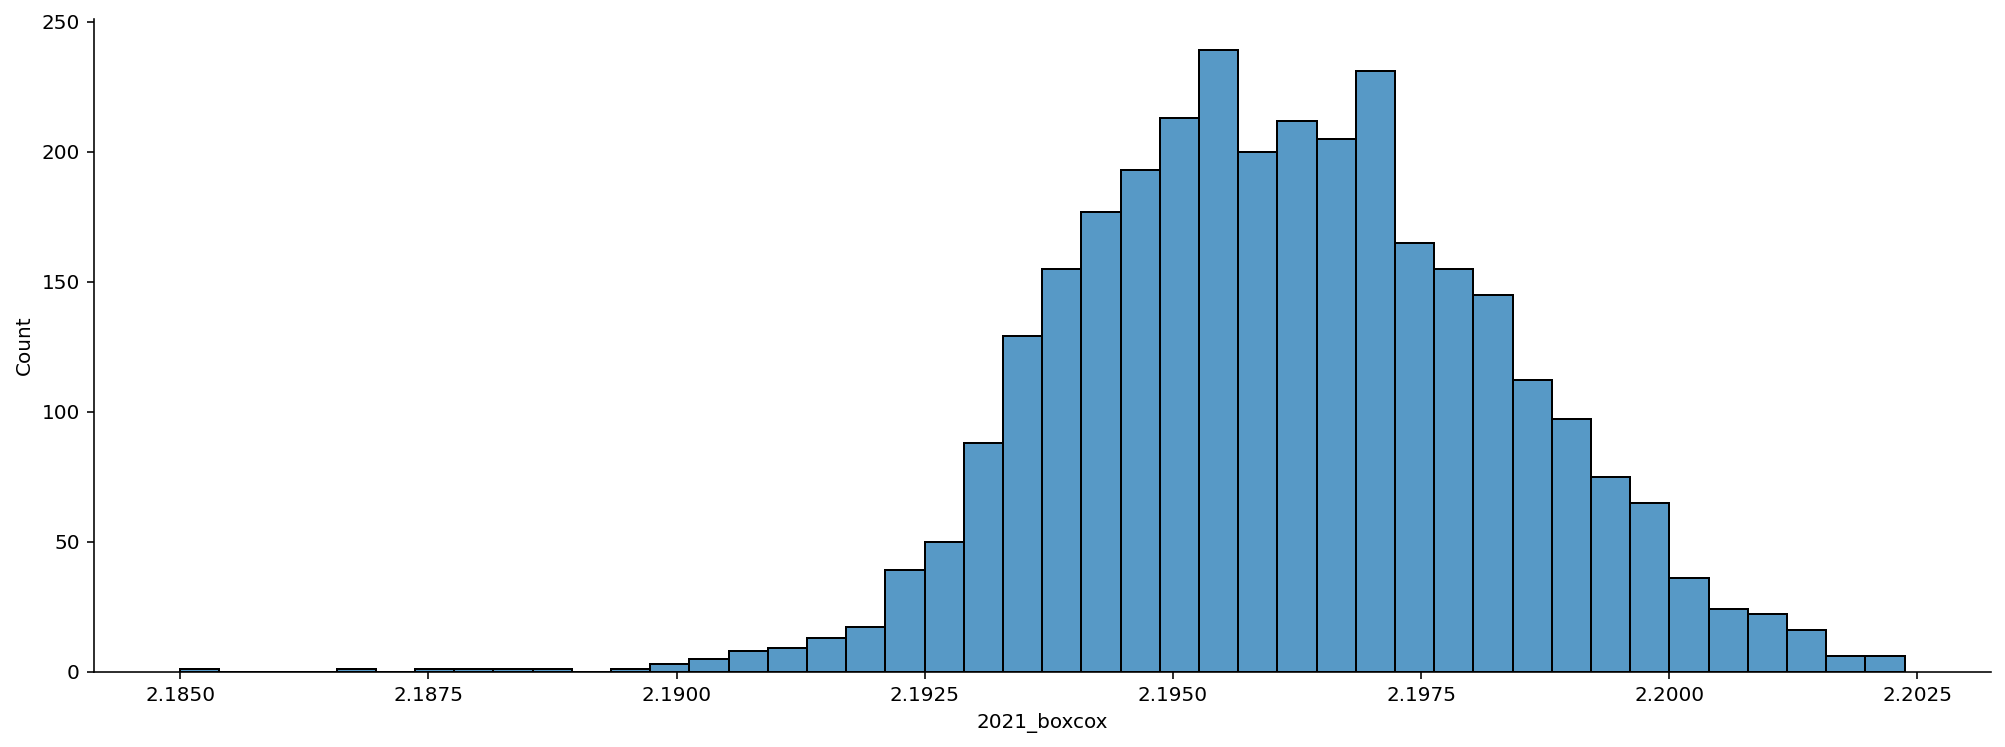

In [208]:
# get distribution of housing price

sns.histplot(x='2021_boxcox', data = df_housing_nri_merged)
ax1.set_title('Housing Price Distribution (2021)')
sns.despine()


## Which counties have the highest and lowest housing prices in 2021?

In [209]:
df_housing_nri_merged.sort_values(by = ['2021'], ascending = False)

,County & State,FIPS,2017,2018,2019,2020,2021,state,state_abbrv,state_fips,...,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,risk_encoded,eal_encoded,2021_boxcox
1851,"New York County, New York",36061,928301.0,1022410.0,1055711.0,1158975.0,1206529.0,New York,NY,36,...,61,1585873,22.656978,34.177655,Relatively High,28.080777,Relatively High,4,4,2.202371
1207,"Nantucket County, Massachusetts",25019,977083.0,1066641.0,1105814.0,1090267.0,1188144.0,Massachusetts,MA,25,...,19,10172,46.112811,1.131330,Very Low,3.030702,Very Low,1,1,2.202344
221,"Santa Clara County, California",06085,939597.0,1081779.0,1089740.0,1123226.0,1159910.0,California,CA,6,...,85,1781642,1291.210369,22.951107,Relatively High,66.140195,Very High,4,5,2.202302
219,"San Mateo County, California",06081,1050406.0,1205405.0,1195477.0,1150016.0,1155499.0,California,CA,6,...,81,718451,448.556757,22.750567,Relatively Moderate,49.029219,Very High,3,5,2.202295
216,"San Francisco County, California",06075,1077650.0,1224255.0,1182325.0,1135007.0,1140419.0,California,CA,6,...,75,805235,46.905643,33.270781,Relatively High,47.986907,Very High,4,5,2.202272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,"King County, Texas",48269,84024.0,41127.0,40460.0,38388.0,40531.0,Texas,TX,48,...,269,286,910.872076,4.415355,Very Low,5.087641,Very Low,1,1,2.188242
2637,"Kent County, Texas",48263,83217.0,74729.0,41938.0,36610.0,38654.0,Texas,TX,48,...,263,808,902.506479,7.386888,Very Low,6.300662,Very Low,1,1,2.187852
2999,"McDowell County, West Virginia",54047,37778.0,35632.0,35192.0,36558.0,37358.0,West Virginia,WV,54,...,47,22113,533.456630,17.076402,Relatively Moderate,13.667560,Relatively Low,3,2,2.187565
2385,"Mellette County, South Dakota",46095,57028.0,46984.0,46644.0,32911.0,34704.0,South Dakota,SD,46,...,95,2048,1307.325748,6.668241,Very Low,5.420596,Very Low,1,1,2.186931


## Let's generate a choropleth for 2021 housing prices

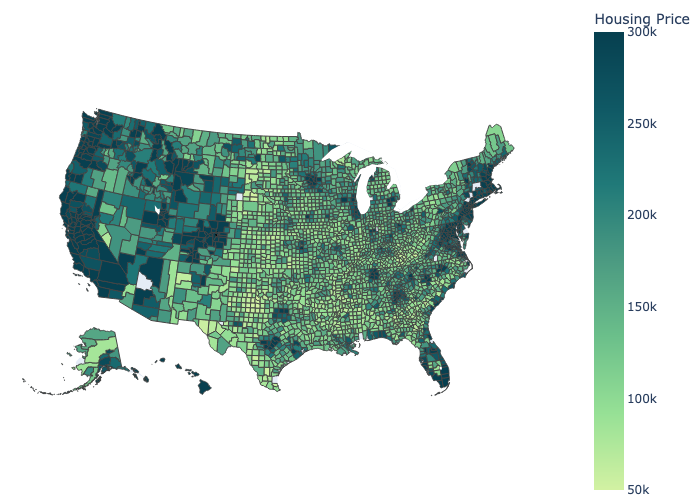

In [210]:
fig = px.choropleth(df_housing_nri_merged, geojson=counties, locations='FIPS', color='2021',
                           color_continuous_scale="Emrld",
                           range_color=(50000, 300000),
                           scope="usa",
                           labels={'2021':'Housing Price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("images/housing_choropleth.png")
Image(filename='images/housing_choropleth.png') 

## At first glance, we don't see any counties that are in the top five or bottom five of both tables.
Let's see the scatter matrix between risk score, expected annual loss, and 2021 housing prices to get a better sense of our relationships.

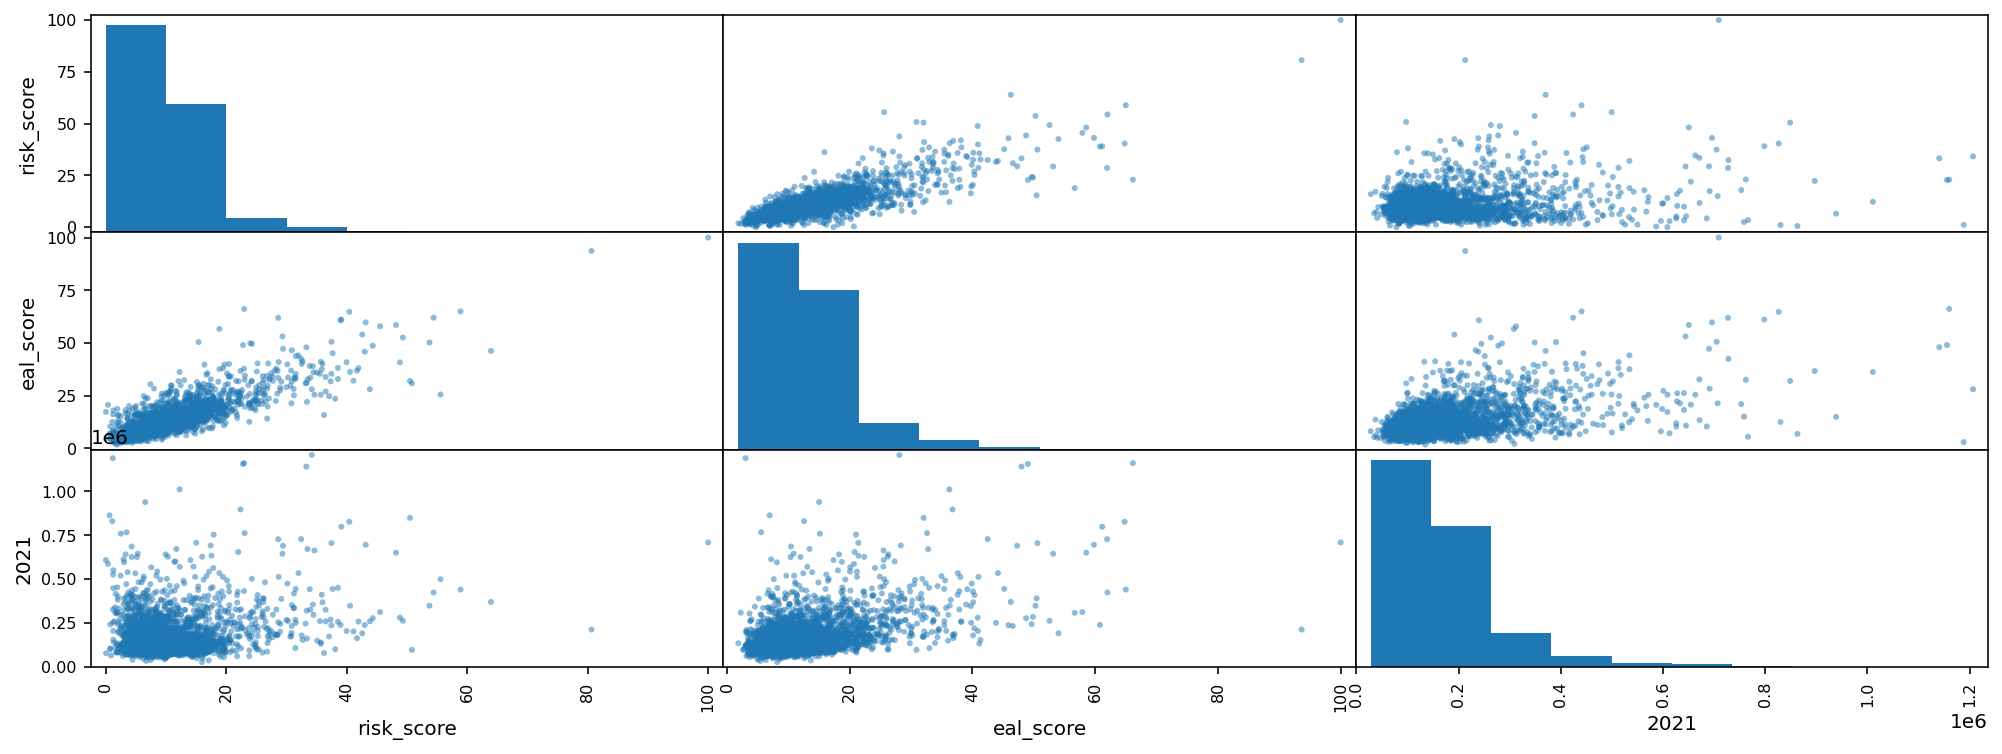

In [211]:
fig = pd.plotting.scatter_matrix(df_housing_nri_merged[['risk_score', 'eal_score', '2021']])

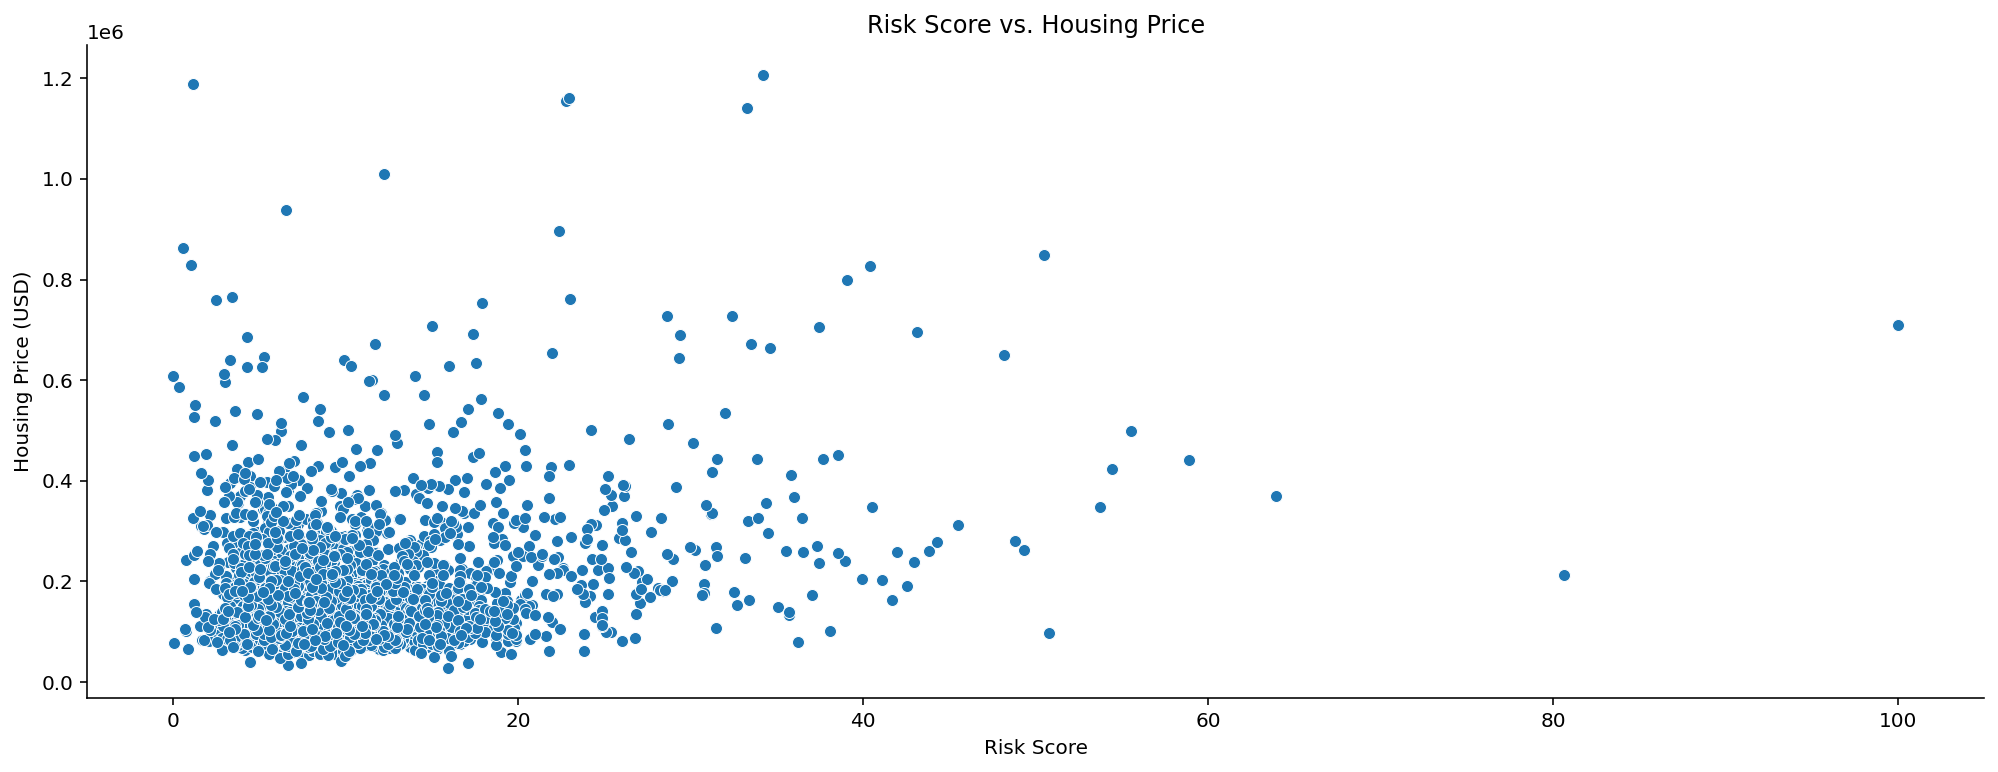

In [212]:
sns.scatterplot(x = 'risk_score', y = '2021', data = df_housing_nri_merged)
plt.xlabel('Risk Score')
plt.ylabel('Housing Price (USD)')
plt.title('Risk Score vs. Housing Price')
sns.despine()

Interesting, there seems to be either a weakly positive correlation (or none at all) between housing prices and risk score.
We can see that there are some counties with a low risk score and a high housing price. Let's now take a look at those counties.

In [213]:
df_housing_nri_merged[(df_housing_nri_merged['2021'] >= 900000) & (df_housing_nri_merged['risk_score'] < 30)]


,County & State,FIPS,2017,2018,2019,2020,2021,state,state_abbrv,state_fips,...,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,risk_encoded,eal_encoded,2021_boxcox
199,"Marin County, California",06041,1037699.0,1124350.0,1059218.0,1005705.0,1010500.0,California,CA,6,...,41,252409,520.456551,12.228515,Relatively Low,36.235953,Relatively High,2,4,2.202048
219,"San Mateo County, California",06081,1050406.0,1205405.0,1195477.0,1150016.0,1155499.0,California,CA,6,...,81,718451,448.556757,22.750567,Relatively Moderate,49.029219,Very High,3,5,2.202295
221,"Santa Clara County, California",06085,939597.0,1081779.0,1089740.0,1123226.0,1159910.0,California,CA,6,...,85,1781642,1291.210369,22.951107,Relatively High,66.140195,Very High,4,5,2.202302
1207,"Nantucket County, Massachusetts",25019,977083.0,1066641.0,1105814.0,1090267.0,1188144.0,Massachusetts,MA,25,...,19,10172,46.112811,1.131330,Very Low,3.030702,Very Low,1,1,2.202344
3112,"Teton County, Wyoming",56039,746088.0,769415.0,867907.0,894286.0,938682.0,Wyoming,WY,56,...,39,21294,3996.855337,6.513988,Very Low,15.004361,Relatively Low,1,2,2.201906


## Linear Regression
We can find statistical signifance between the two variables using a linear regression. We will use our transformed values (boxcox, log 10) in this analysis.

In [214]:
# we do a log(x + .1) transformation because some x == 0 and we are unable to log those.
df_housing_nri_merged['risk_score_log10'] = np.log10(df_housing_nri_merged['risk_score'] + .1) 
df_housing_nri_merged['eal_score_log10'] = np.log10(df_housing_nri_merged['eal_score'] + .1) 

In [216]:
outcome, predictors = patsy.dmatrices('Q("2021_boxcox") ~ risk_score_log10', df_housing_nri_merged)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("2021_boxcox")   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.33
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           0.000266
Time:                        10:14:15   Log-Likelihood:                 14765.
No. Observations:                3117   AIC:                        -2.953e+04
Df Residuals:                    3115   BIC:                        -2.951e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.1956      0.000  

In [217]:
outcome, predictors = patsy.dmatrices('Q("2021_boxcox") ~ eal_score_log10', df_housing_nri_merged)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       Q("2021_boxcox")   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     641.8
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          6.61e-129
Time:                        10:14:22   Log-Likelihood:                 15051.
No. Observations:                3117   AIC:                        -3.010e+04
Df Residuals:                    3115   BIC:                        -3.009e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1916      0.000    1